In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/pyTracker/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/pyTracker/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import datatypes
from datatypes import *

reload(TF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/pyTracker/tracker/utilities.py'>

# Defining Useful Functions #

In [19]:
steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

y_bottoms = [8550, 8631.6]
z_walls = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [23]:
def SortByTime(points):
    """
    Sorts list hits by time
    A hit is of the form (x,y,z,t)
    """
    if len(points) <= 1:
        return points
    pivot = points[len(points) // 2]
    left = []
    middle = []
    right = []
    for point in points:
        if point[-1] < pivot[-1]:
            left.append(point)
        elif point[-1] > pivot[-1]:
            right.append(point)
        elif point[-1] == pivot[-1]:
            middle.append(point)
    return SortByTime(left) + middle + SortByTime(right)


def GoingUp(points):
    """
    Takes a sorted list of points and check if it is going up.
    If it is, return True
    """
    for i in range(1, len(points)):
        if points[i-1][1] > points[i][1]:
            return False
    return True


def ProjectionTime(track, points, layer):
    """
    Takes a track and its SORTED list of points
    closest is true if you want to check in the closest wall/floor,
    false if you wanna check in the farther wall/floor
    Returns the time at which the track is 
    projected to enter the wall or floor
    Given point is (x,y,z,t)
    """
    if layer == 0:# Walls
        if track.Ay == 1: # Horizontal layer track 
            return track.At/track.Az*(wallMid1 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid1 - points[0][2]) + points[0][3]
    elif layer == 1:
        if track.Ay == 1: # Horizontal layer track
            return track.At/track.Az*(wallMid2 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid2 - points[0][2]) + points[0][3]
    elif layer == 2: # Floors
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid1 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid1 - points[0][1]) + points[0][3]
    elif layer == 3: 
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid2 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid2 - points[0][1]) + points[0][3]


def ProjectionPoint(track, points, t):
    """
    Returns where the track is projected to be at time t.
    points is the list of hits from the track sorted by time
    Returns an empty array if out of the detector
    """
    if track.Ay == 1: #Horizontal layer track
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + 1/track.At * (t - points[0][3])
        zf = points[0][2] + track.Az/track.At*(t - points[0][3])
    else: # Vertical layer track 
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + track.Ay/track.At * (t - points[0][3])
        zf = points[0][2] + 1/track.At*(t - points[0][3])
    return np.array((xf,yf,zf))


def ProjectionCovariance(track, points, t):
    """
    Returns the projected covariance of x,y,z at time t.
    covariance is x,z,t,Ax,Az,At if horizontal track, or 
    x,y,t,Ax,Ay,At if vertical track.
    points is sorted by time
    """
    dt = t - points[0][3]
    if track.Ay == 1: # Horizontal track
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2],
                        [0, 1, -track.Az/track.At, 0, dt/track.At, -track.Az*dt/track.At**2]])
    else: 
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 1, -track.Ay/track.At, 0, dt/track.At, -track.Ay*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2]])    
    return Jac@track.cov@Jac.T


def GetChiSquared(hit, track):
    """
    Get the chi squared between a track projection and the hit
    """
    TrackPoints = SortByTime(track.hits_filtered)
    hit_pos = np.array((hit.x, hit.y, hit.z))
    hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
    proj_time = hit.t
    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
    if proj_point is None:
        return None
    proj_cov = ProjectionCovariance(track, TrackPoints, proj_time)
    proj_cov += np.diag(hit_err)**2
    residual = proj_point - hit_pos 
    try:
        inv_cov = np.linalg.inv(proj_cov)
    except:
        return None
    return residual.T @ inv_cov @ residual


def GetDistance(point1, point2):
    """
    Get the distance between two points (x,y,z)
    """
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)




# Background #

In [24]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

187


## Chi2 and Distance Distribution (Track Level) ##

### Chi 2 Distribution ###

In [7]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_chi2 = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                cur_chi2 = GetChiSquared(hit,track)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
                    min_hit = hit
                    min_time = abs(proj_time - hit.t)
                    min_point = proj_point
            if min_hit is None:
                continue
            dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 50:
                chi2s.append(chi2_red)
                distances.append(dist)
                times.append(min_time)

[1.99647021]
[[0.00302564]]


Text(0, 0.5, 'chi2')

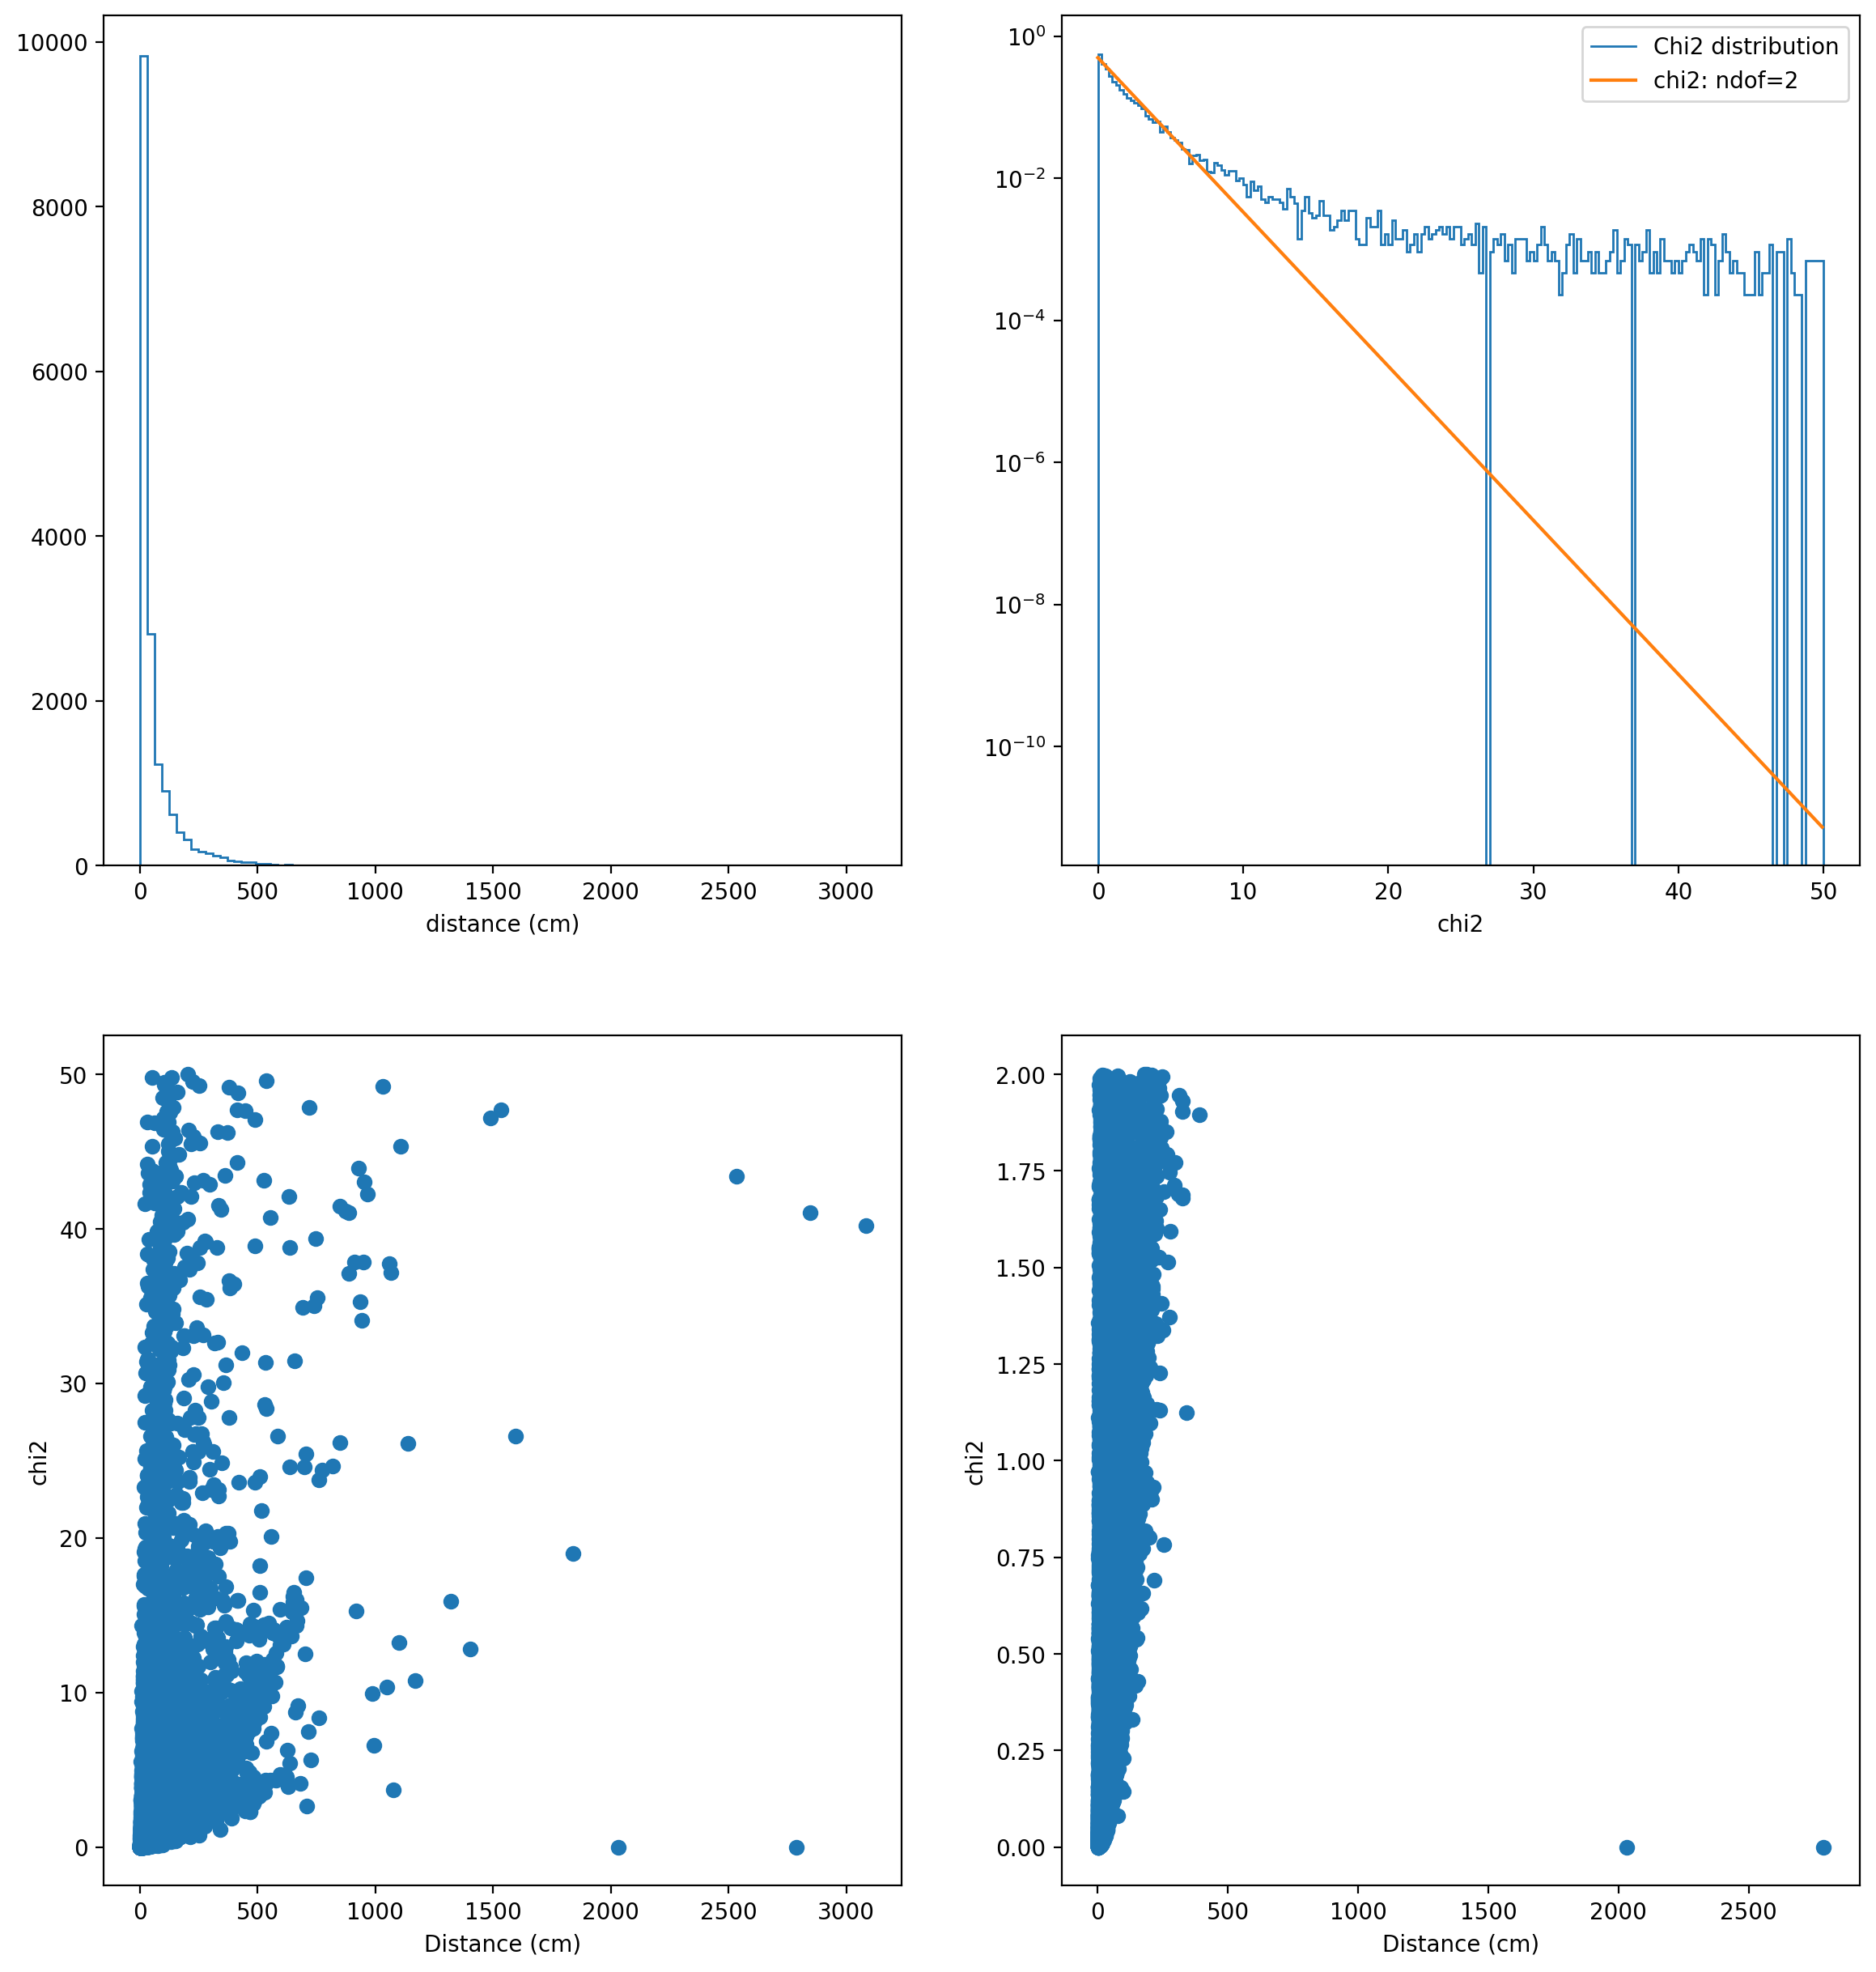

In [8]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 10:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)

# chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2: ndof=2")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("chi2")

### Distance Distribution ###

In [7]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_dist = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                if proj_point is None:
                    continue
                dist = GetDistance(proj_point, hit_pos)
                if dist is not None and (min_dist is None or dist < min_dist):
                    min_dist = dist
            if min_dist is None:
                continue
            distances.append(min_dist)


Text(0.5, 1.0, 'Background Distance Distribution')

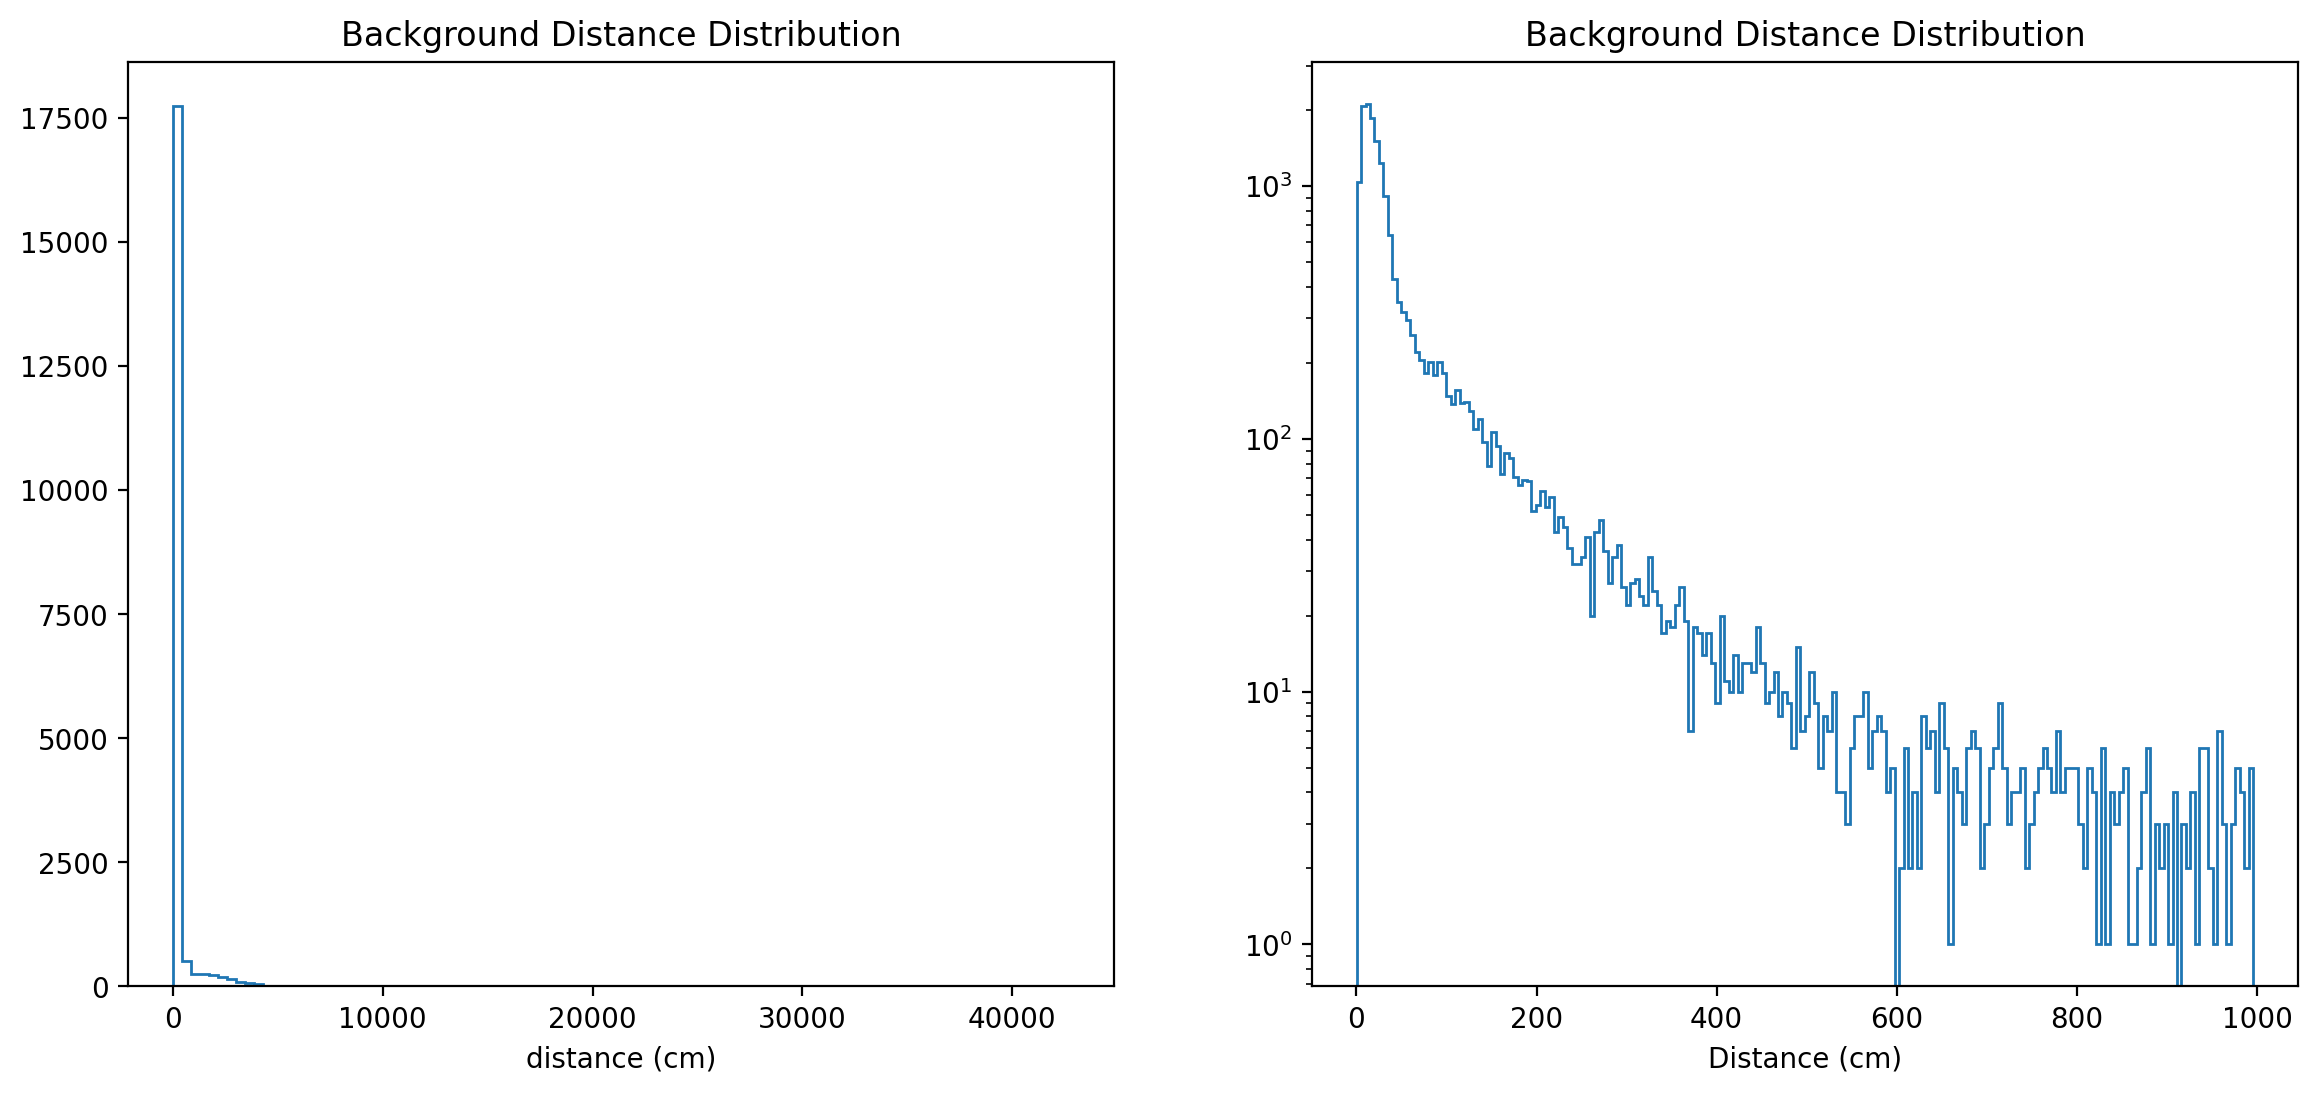

In [9]:
fig,axs=plt.subplots(1,2,figsize=(14,6))
axs=axs.flatten().tolist()

zoomeddist = []
for dist in distances:
    if dist < 1000:
        zoomeddist.append(dist)

distancesCounts, distancesBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=200)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_title("Background Distance Distribution")
axs[1].stairs(zoomedCounts[:int(len(zoomedCounts)/1)], zoomedBins[:int(len(zoomedBins)/1) + 1], label="distances")
axs[1].set_yscale('log')
axs[1].set_xlabel("Distance (cm)")
axs[1].set_title("Background Distance Distribution")

## Chi2 and Distance Distribution (Event Level) ##

### Chi2 Distribution ###

In [51]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_hit = None
        min_chi2 = None
        min_time = None
        min_point = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                    proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
                        min_hit = hit
                        min_time = abs(proj_time - hit.t)
                        min_point = proj_point
        if min_hit is None:
            continue
        dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 50:
            chi2s.append(chi2_red)
            distances.append(dist)
            times.append(min_time)

[1.]
[[nan]]


/home/owhgabri/environments/mathusla/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


Text(0, 0.5, 'chi2')

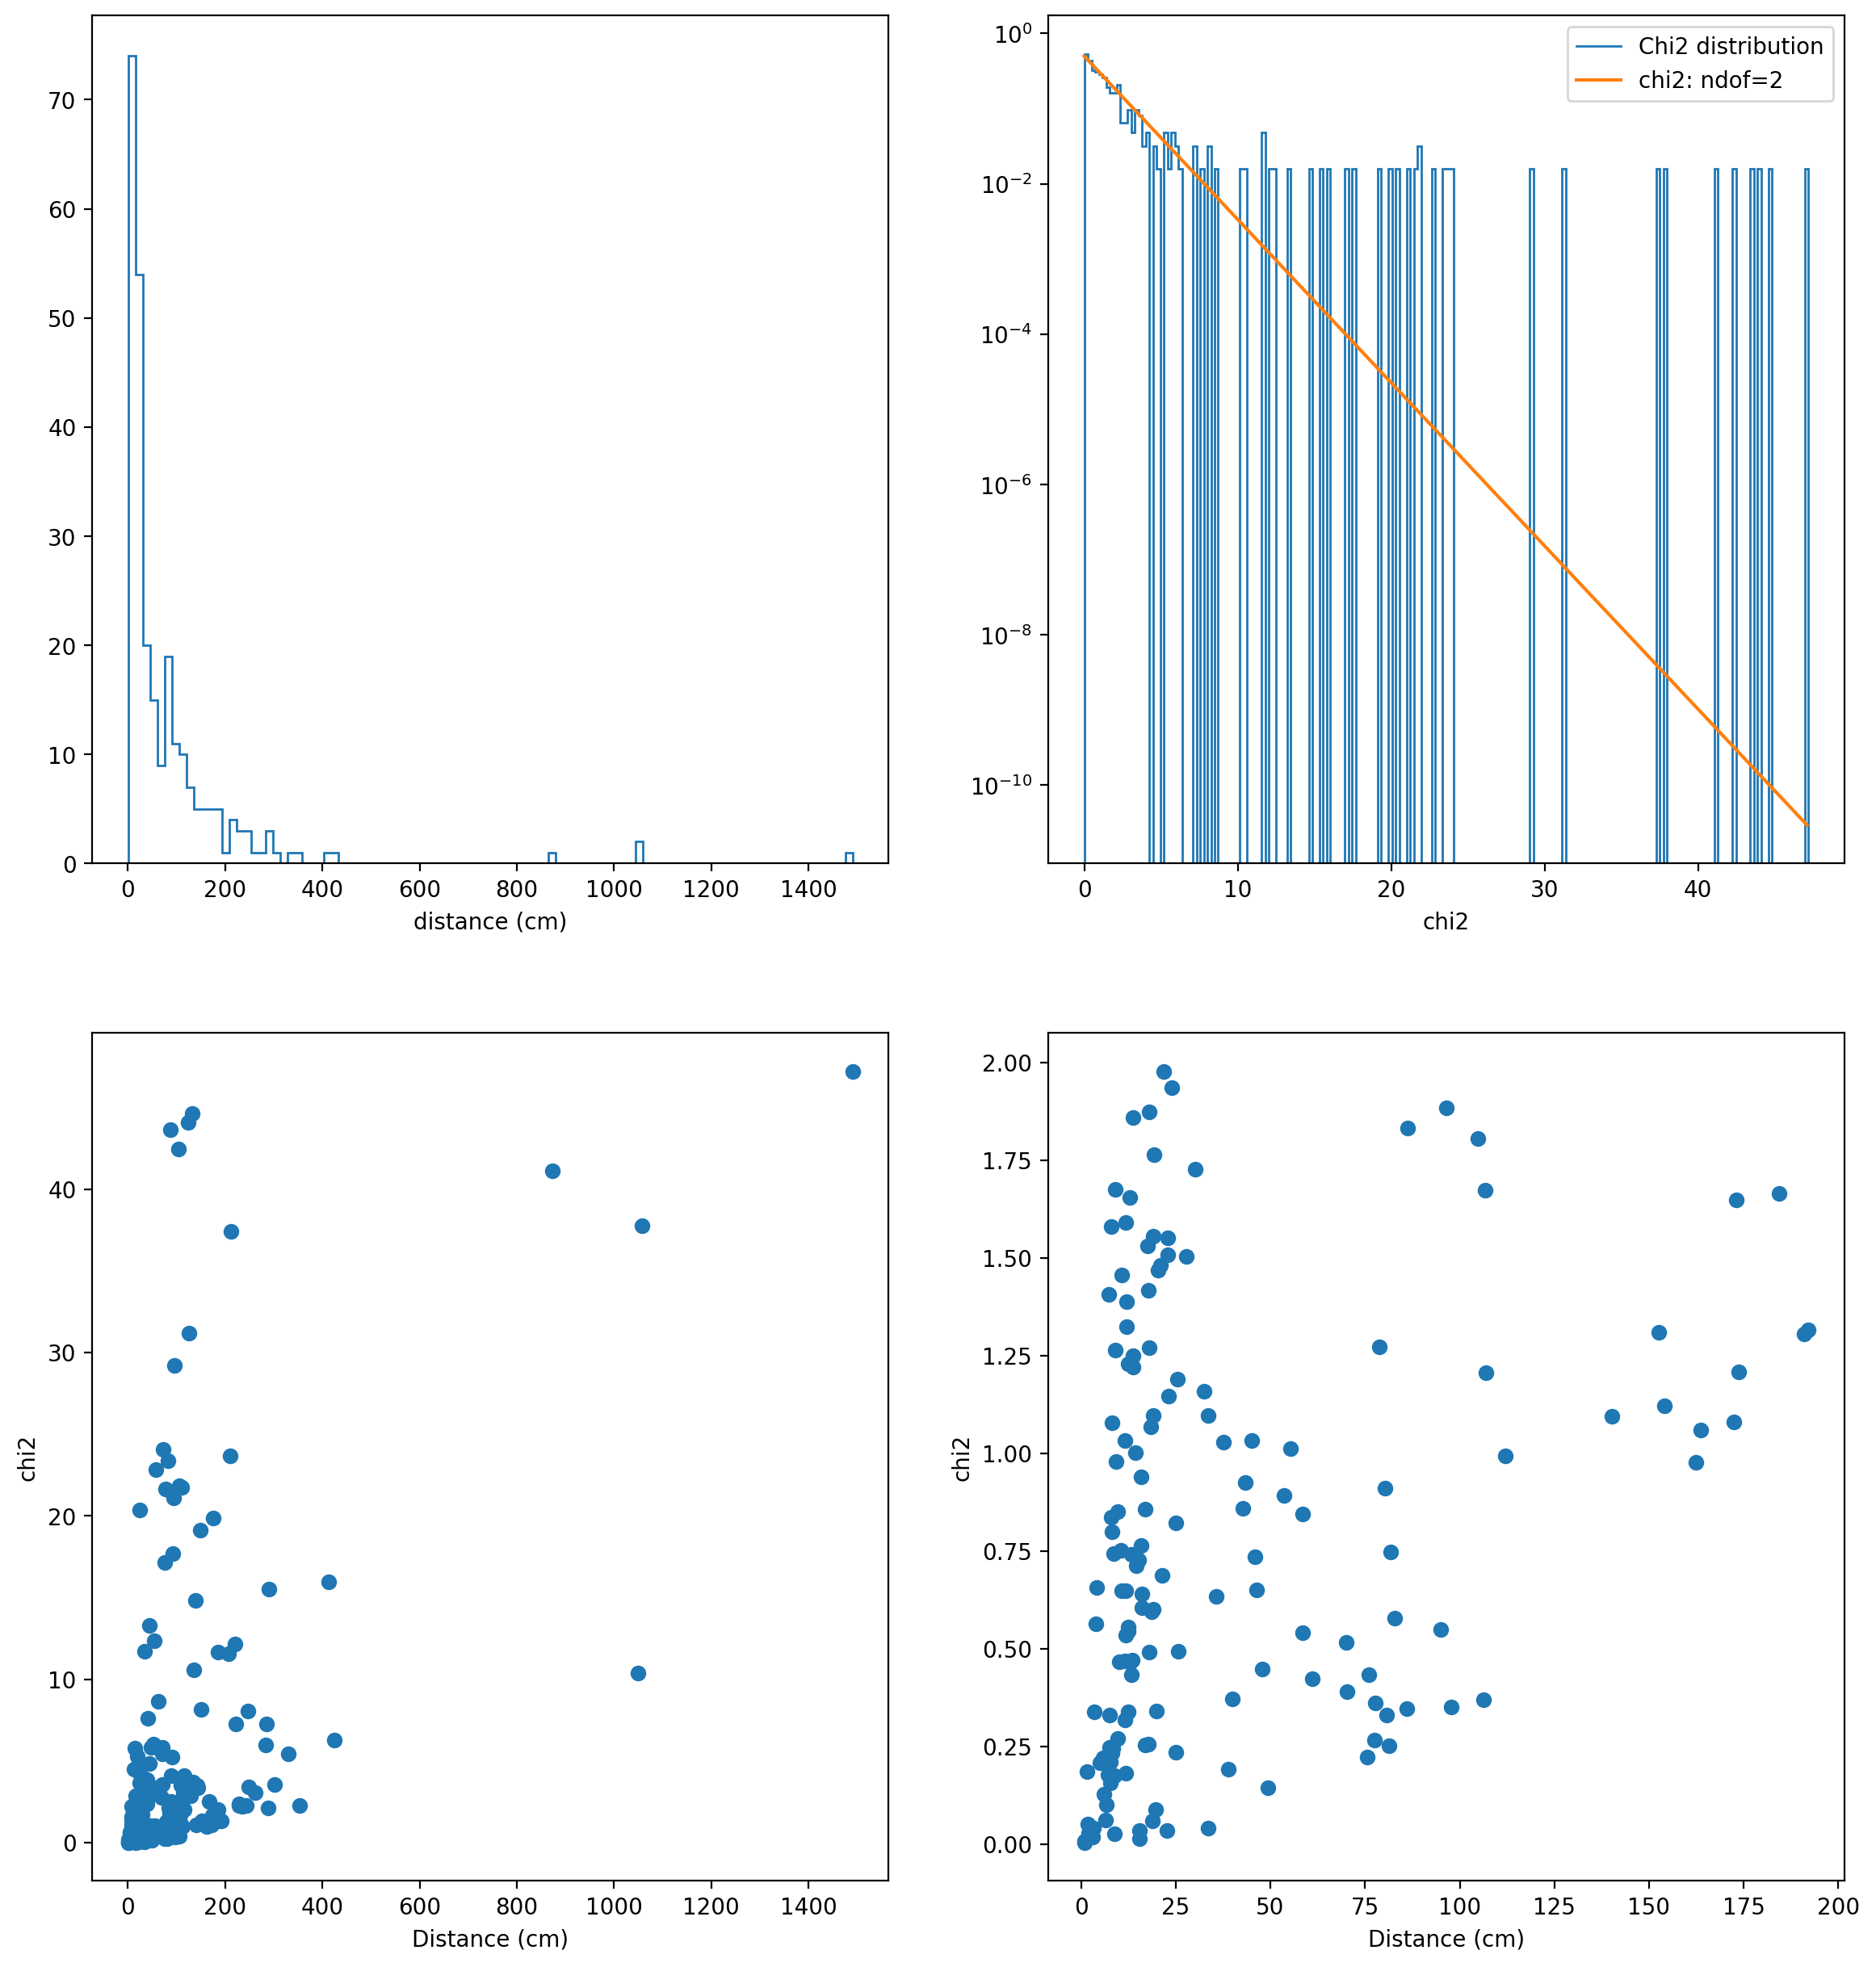

In [52]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 10:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)

# chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2: ndof=2")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("chi2")

### Distance Distribution ###

In [10]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_dist = None
        for track in tracks:
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                if proj_point is None:
                    continue
                dist = GetDistance(proj_point, hit_pos)
                if dist is not None and (min_dist is None or dist < min_dist):
                    min_dist = dist
        if min_dist is None:
            continue
        distances.append(min_dist)


Text(0.5, 1.0, 'Background Distance Distribution')

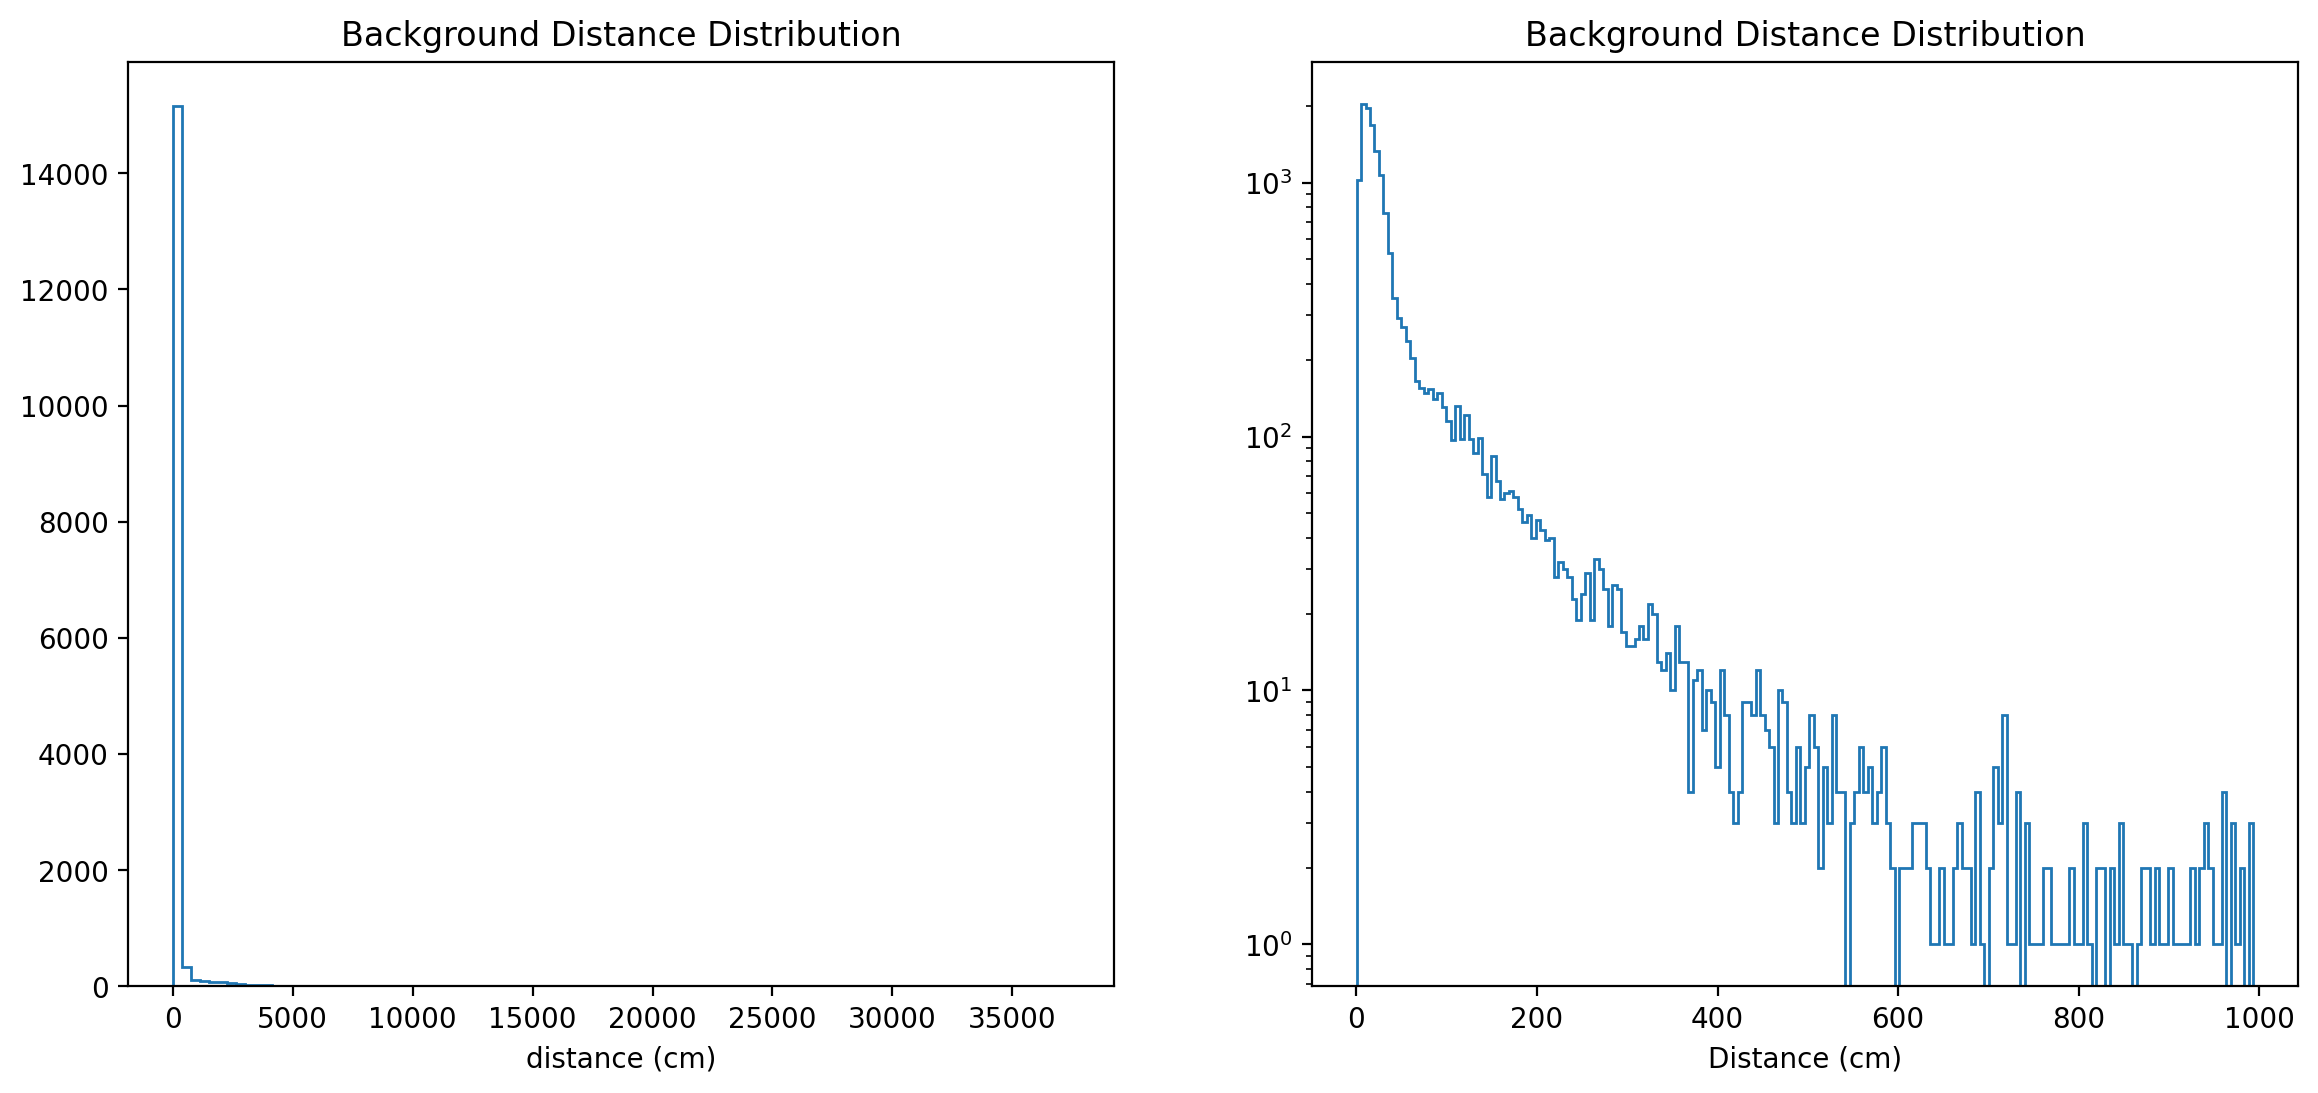

In [11]:
fig,axs=plt.subplots(1,2,figsize=(14,6))
axs=axs.flatten().tolist()

zoomeddist = []
for dist in distances:
    if dist < 1000:
        zoomeddist.append(dist)

distancesCounts, distancesBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=200)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_title("Background Distance Distribution")
axs[1].stairs(zoomedCounts[:int(len(zoomedCounts)/1)], zoomedBins[:int(len(zoomedBins)/1) + 1], label="distances")
axs[1].set_yscale('log')
axs[1].set_xlabel("Distance (cm)")
axs[1].set_title("Background Distance Distribution")

## Track Veto Efficiency ##

### Survival Rate for given Chi2 Values ###

In [11]:
chi2s = []
distances = []
times = []
nTotalTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        nTotalTracks += len(tracks)
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_chi2 = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                cur_chi2 = GetChiSquared(hit,track)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
                    min_hit = hit
                    min_time = abs(proj_time - hit.t)
                    min_point = proj_point
            if min_hit is None:
                continue
            dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 50:
                chi2s.append(chi2_red)
                distances.append(dist)
                times.append(min_time)

Fraction surviving after chi2=1 cut: 0.6398725961438767
Fraction surviving after chi2=5 cut: 0.3151710952501421
Fraction surviving after chi2=7 cut: 0.271197687487299
Fraction surviving after chi2=10 cut: 0.24018032290573688


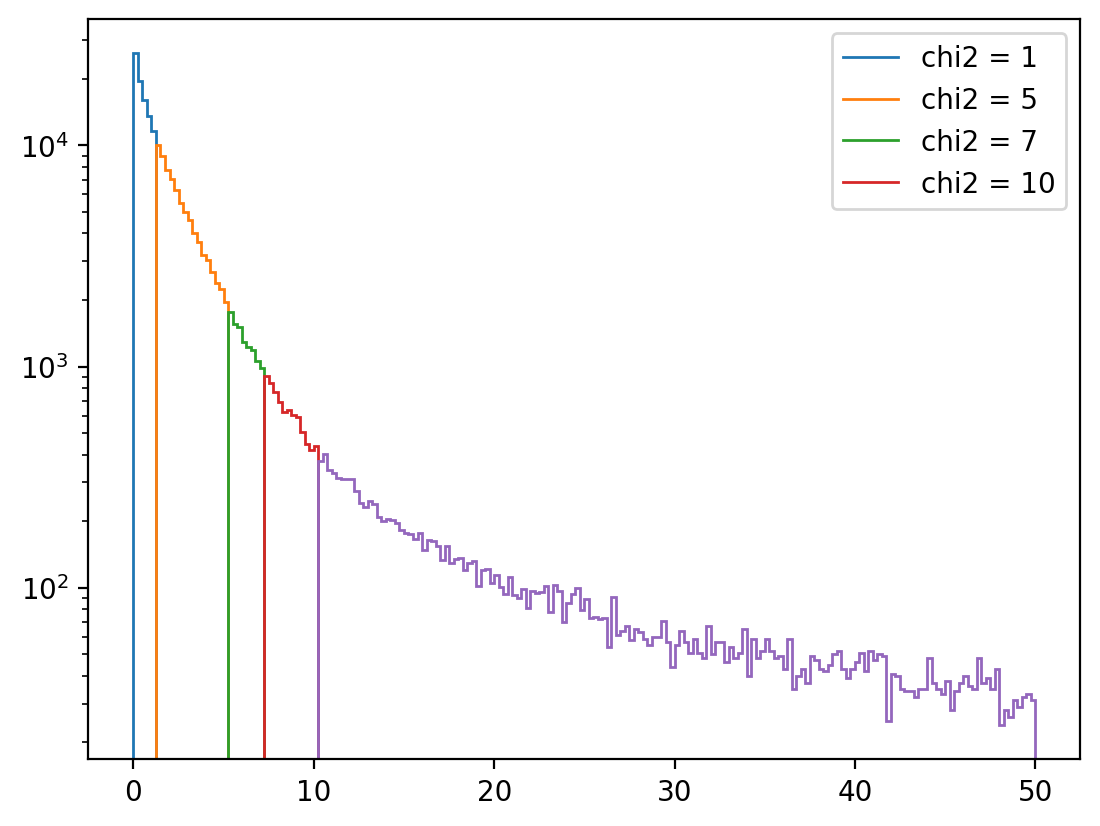

In [12]:
chi2_1Counts = []
chi2_5Counts = []
chi2_7Counts = []
chi2_10Counts = []
chi2_restCounts = []

chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

i=0
start_1 = 0
while chi2Bins[i] < 1:
    chi2_1Counts.append(chi2Counts[i])
    i+=1
n_1Bins = chi2Bins[start_1:start_1 + len(chi2_1Counts)+1]
start_5 = i
while chi2Bins[i] < 5:
    chi2_5Counts.append(chi2Counts[i])
    i+=1
n_5Bins = chi2Bins[start_5:start_5 + len(chi2_5Counts)+1]
start_7 = i
while chi2Bins[i] < 7:
    chi2_7Counts.append(chi2Counts[i])
    i+=1
n_7Bins = chi2Bins[start_7:start_7 + len(chi2_7Counts)+1]
start_10 = i
while chi2Bins[i] < 10:
    chi2_10Counts.append(chi2Counts[i])
    i+=1
n_10Bins = chi2Bins[start_10:start_10 + len(chi2_10Counts)+1]
start_rest = i
while i < len(chi2Bins) - 1:
    chi2_restCounts.append(chi2Counts[i])
    i+=1
n_rest = chi2Bins[start_rest:start_rest + len(chi2_restCounts)+1]
frac_1 = 1 - sum(chi2_1Counts)/nTotalTracks; frac_5 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts))/nTotalTracks
frac_7 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts) + sum(chi2_7Counts))/nTotalTracks
frac_10 = 1 - (sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nTotalTracks
print("Fraction surviving after chi2=1 cut:", frac_1)
print("Fraction surviving after chi2=5 cut:", frac_5)
print("Fraction surviving after chi2=7 cut:", frac_7)
print("Fraction surviving after chi2=10 cut:", frac_10)
plt.stairs(chi2_1Counts, n_1Bins, label="chi2 = 1")
plt.stairs(chi2_5Counts, n_5Bins, label="chi2 = 5")
plt.stairs(chi2_7Counts, n_7Bins, label="chi2 = 7")
plt.stairs(chi2_10Counts, n_10Bins,label="chi2 = 10")
plt.stairs(chi2_restCounts, n_rest)
plt.yscale('log')
plt.legend()

### Survival Rate for Given Distance Values ###

In [13]:
distances = []
nTotalTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        nTotalTracks += len(tracks)
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_dist = None
            for hit in wf_hits:
                hit_pos = np.array((hit.x, hit.y, hit.z))
                TrackPoints = SortByTime(track.hits_filtered)
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                if proj_point is not None:
                    dist = GetDistance(hit_pos, proj_point)
                if (min_dist is None or dist < min_dist):
                    min_dist = dist
            if min_dist is None:
                continue
            distances.append(min_dist)


999.9721461453487
Fraction surviving after d=100 cut: 0.3056116587799588
Fraction surviving after d=200 cut: 0.20346462179053848
Fraction surviving after d=300 cut: 0.15956171746370107
Fraction surviving after d=500 cut: 0.12430585219991452


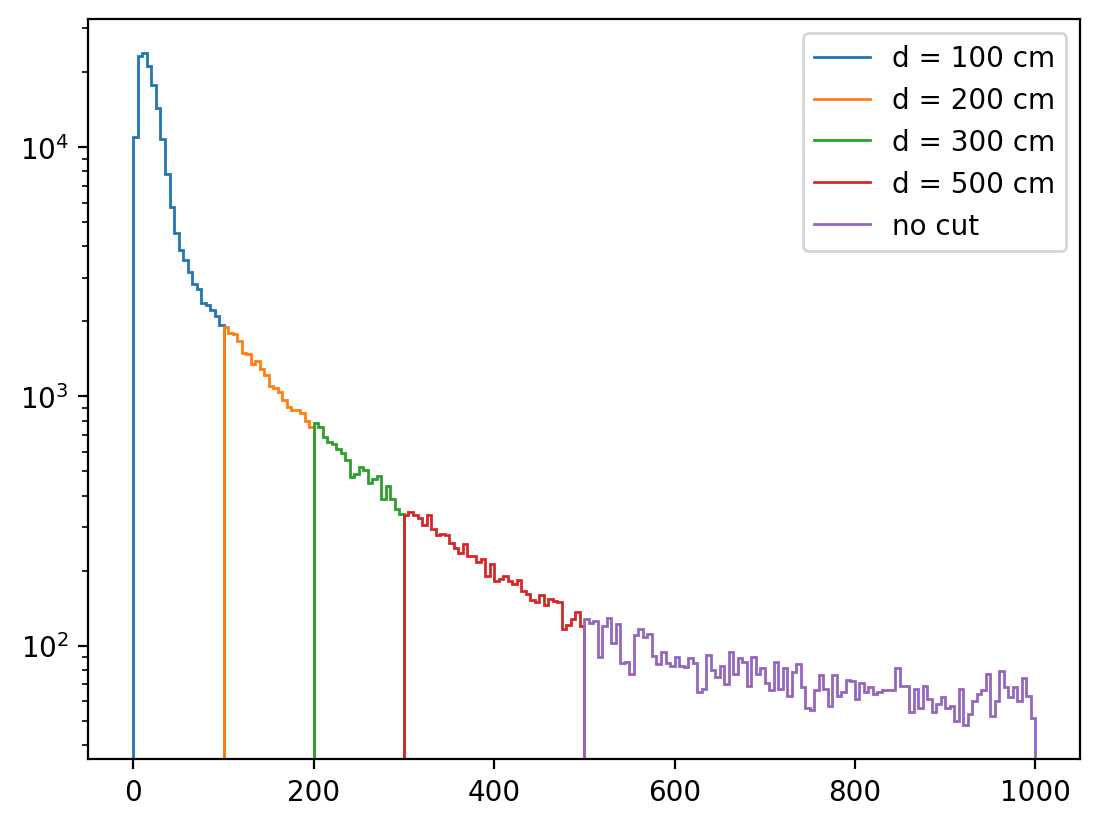

In [14]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dist_shortened = []
for dist in distances:
    if dist < 1000:
        dist_shortened.append(dist)
dCounts, dBins = np.histogram(dist_shortened, bins=200)
print(dBins[-1])

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nTotalTracks; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nTotalTracks
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nTotalTracks
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nTotalTracks
print("Fraction surviving after d=100 cut:", frac_1)
print("Fraction surviving after d=200 cut:", frac_2)
print("Fraction surviving after d=300 cut:", frac_3)
print("Fraction surviving after d=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="d = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="d = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="d = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="d = 500 cm")
plt.stairs(d_restCounts, n_rest, label="no cut")
plt.yscale('log')
plt.legend()

## Event Veto Efficiency ##

### Survival Rate for given Chi2 Values ###

In [25]:
chi2s = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_chi2 = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
        if min_chi2 is None:
            continue
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 101:
            chi2s.append(chi2_red)
print("Total Events (with at least one vertex):", nEvents)

Total Events (with at least one vertex): 3686


Fraction surviving after chi2=1 cut: 0.8106348345089528
Fraction surviving after chi2=5 cut: 0.45713510580575145
Fraction surviving after chi2=7 cut: 0.3996201844818231
Fraction surviving after chi2=10 cut: 0.3442756375474769
Fraction surviving after chi2=15 cut: 0.2932718393922952
Fraction surviving after chi2=20 cut: 0.2558328811720022
Fraction surviving after chi2=50 cut: 0.16576234400434076
Fraction surviving after chi2=100 cut: 0.1025501899077591


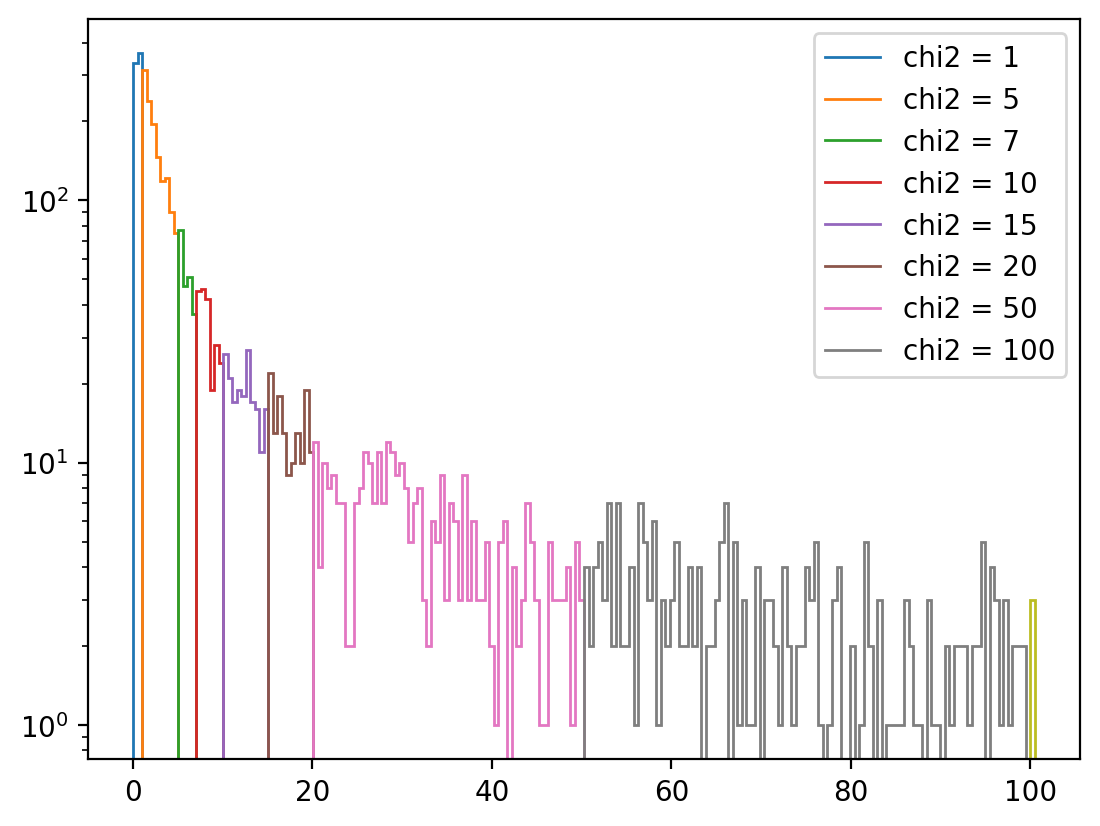

In [26]:
chi2_1Counts = []
chi2_5Counts = []
chi2_7Counts = []
chi2_10Counts = []
chi2_15Counts = []
chi2_20Counts = []
chi2_50Counts = []
chi2_100Counts = []
chi2_restCounts = []

chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

i=0
start_1 = 0
while chi2Bins[i] < 1:
    chi2_1Counts.append(chi2Counts[i])
    i+=1
n_1Bins = chi2Bins[start_1:start_1 + len(chi2_1Counts)+1]
start_5 = i
while chi2Bins[i] < 5:
    chi2_5Counts.append(chi2Counts[i])
    i+=1
n_5Bins = chi2Bins[start_5:start_5 + len(chi2_5Counts)+1]
start_7 = i
while chi2Bins[i] < 7:
    chi2_7Counts.append(chi2Counts[i])
    i+=1
n_7Bins = chi2Bins[start_7:start_7 + len(chi2_7Counts)+1]
start_10 = i
while chi2Bins[i] < 10:
    chi2_10Counts.append(chi2Counts[i])
    i+=1
n_10Bins = chi2Bins[start_10:start_10 + len(chi2_10Counts)+1]
start_15 = i
while chi2Bins[i] < 15:
    chi2_15Counts.append(chi2Counts[i])
    i+=1
n_15Bins = chi2Bins[start_15:start_15 + len(chi2_15Counts)+1]
start_20 = i
while chi2Bins[i] < 20:
    chi2_20Counts.append(chi2Counts[i])
    i+=1
n_20Bins = chi2Bins[start_20:start_20 + len(chi2_20Counts)+1]
start_50 = i
while chi2Bins[i] < 50:
    chi2_50Counts.append(chi2Counts[i])
    i+=1
n_50Bins = chi2Bins[start_50:start_50 + len(chi2_50Counts)+1]
start_100 = i
while chi2Bins[i] < 100:
    chi2_100Counts.append(chi2Counts[i])
    i+=1
n_100Bins = chi2Bins[start_100:start_100 + len(chi2_100Counts)+1]
start_rest = i
while i < len(chi2Bins) - 1:
    chi2_restCounts.append(chi2Counts[i])
    i+=1
n_rest = chi2Bins[start_rest:start_rest + len(chi2_restCounts)+1]
frac_1 = 1 - sum(chi2_1Counts)/nEvents; frac_5 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts))/nEvents
frac_7 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts) + sum(chi2_7Counts))/nEvents
frac_10 = 1 - (sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_15 = 1 - (sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_20 = 1 - (sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_50 = 1 - (sum(chi2_50Counts) + sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_100 = 1 - (sum(chi2_100Counts) + sum(chi2_50Counts) + sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents

print("Fraction surviving after chi2=1 cut:", frac_1)
print("Fraction surviving after chi2=5 cut:", frac_5)
print("Fraction surviving after chi2=7 cut:", frac_7)
print("Fraction surviving after chi2=10 cut:", frac_10)
print("Fraction surviving after chi2=15 cut:", frac_15)
print("Fraction surviving after chi2=20 cut:", frac_20)
print("Fraction surviving after chi2=50 cut:", frac_50)
print("Fraction surviving after chi2=100 cut:", frac_100)
plt.stairs(chi2_1Counts, n_1Bins, label="chi2 = 1")
plt.stairs(chi2_5Counts, n_5Bins, label="chi2 = 5")
plt.stairs(chi2_7Counts, n_7Bins, label="chi2 = 7")
plt.stairs(chi2_10Counts, n_10Bins,label="chi2 = 10")
plt.stairs(chi2_15Counts, n_15Bins,label="chi2 = 15")
plt.stairs(chi2_20Counts, n_20Bins,label="chi2 = 20")
plt.stairs(chi2_50Counts, n_50Bins,label="chi2 = 50")
plt.stairs(chi2_100Counts, n_100Bins,label="chi2 = 100")

plt.stairs(chi2_restCounts, n_rest)
plt.yscale('log')
plt.legend()

### Survival Rate for Given Distance Values ###

In [11]:
distances = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_dist = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    TrackPoints = SortByTime(track.hits_filtered)
                    proj_time = hit.t
                    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                    if proj_point is not None:
                        dist = GetDistance(hit_pos, proj_point)
                    if (min_dist is None or dist < min_dist):
                        min_dist = dist
        if min_dist is None:
            continue
        distances.append(min_dist)
print("Number of events with at least one vertex:", nEvents)


Number of events with at least one vertex: 3686


Fraction surviving after d=100 cut: 0.3279978296256104
Fraction surviving after d=200 cut: 0.18638090070537172
Fraction surviving after d=300 cut: 0.11855670103092786
Fraction surviving after d=500 cut: 0.07840477482365704
Fraction surviving after d=700 cut: 0.0699945740640261
Fraction surviving after d=1000 cut: 0.0629408572978839


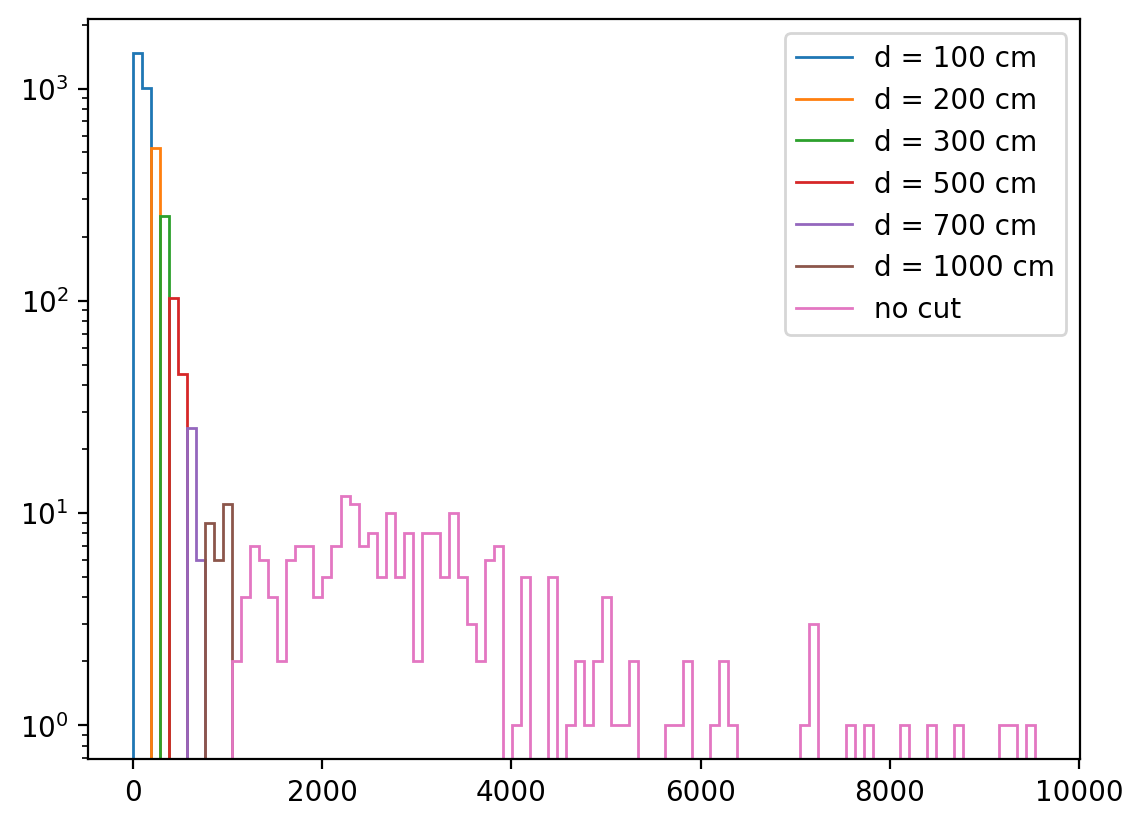

In [12]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_7Counts = []
d_10Counts = []
d_restCounts = []

dist_shortened = []
for dist in distances:
    if dist < 10001:
        dist_shortened.append(dist)
dCounts, dBins = np.histogram(dist_shortened, bins=100)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_7 = i
while dBins[i] < 700:
    d_7Counts.append(dCounts[i])
    i+=1
n_7Bins = dBins[start_7:start_7 + len(d_7Counts)+1]
start_10 = i
while dBins[i] < 1000:
    d_10Counts.append(dCounts[i])
    i+=1
n_10Bins = dBins[start_10:start_10 + len(d_10Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nEvents; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nEvents
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nEvents
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nEvents
frac_7 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts) + sum(d_7Counts))/nEvents
frac_10 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts) + sum(d_7Counts) + sum(d_10Counts))/nEvents

print("Fraction surviving after d=100 cut:", frac_1)
print("Fraction surviving after d=200 cut:", frac_2)
print("Fraction surviving after d=300 cut:", frac_3)
print("Fraction surviving after d=500 cut:", frac_5)
print("Fraction surviving after d=700 cut:", frac_7)
print("Fraction surviving after d=1000 cut:", frac_10)

plt.stairs(d_1Counts, n_1Bins, label="d = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="d = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="d = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="d = 500 cm")
plt.stairs(d_7Counts, n_7Bins, label="d = 700 cm")
plt.stairs(d_10Counts, n_10Bins, label="d = 1000 cm")
plt.stairs(d_restCounts, n_rest, label="no cut")
plt.yscale('log')
plt.legend()

## Chi2 Distribution at Different Cutoffs ##

In [23]:
cutoffs = [1,2,5,10,15,20,35,50,100]
chi2s = []
nTracks = 0
nEvents = 0
nIncluded = 0
for cutoff in cutoffs:
    chi2s.append([])

for cut in cutoffs:
    for f in pathList:
        events=joblib.load(f)
        file_hits = events["hits"]
        file_tracks = events["tracks"]
        for i in range(len(file_hits)):
            hits = file_hits[i]
            tracks = file_tracks[i]
            nTracks += len(tracks)
            wf_hits = []
            for hit in hits:
                if hit.layer < 4:
                    wf_hits.append(hit)
            if len(wf_hits) == 0:
                continue
                
            for track in tracks:
                min_chi2 = None
                for hit in wf_hits:
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
                
                if min_chi2 is None:
                    continue
                nIncluded += 1
                chi2_red = min_chi2
                for i in range(len(cutoffs)):
                    if chi2_red >0 and chi2_red < cutoffs[i]:
                        chi2s[i].append(chi2_red)

ndof for chi2 cutoff of 1 : 1.951127331476667 +/- 0.011334253616773479
Efficiency: 0.3258587786259542
ndof for chi2 cutoff of 2 : 1.9685821168998139 +/- 0.006727892207232213
Efficiency: 0.4834446564885496
ndof for chi2 cutoff of 5 : 1.9853308756221508 +/- 0.0022712954564900376
Efficiency: 0.6884541984732825
ndof for chi2 cutoff of 10 : 1.9906422165512982 +/- 0.002143840135949799
Efficiency: 0.7657442748091603
ndof for chi2 cutoff of 15 : 1.9924978054315428 +/- 0.0023116065833579495
Efficiency: 0.7872614503816794
ndof for chi2 cutoff of 20 : 1.9942051820968756 +/- 0.00236586700097749
Efficiency: 0.7976145038167939
ndof for chi2 cutoff of 35 : 1.998221613279676 +/- 0.0023534652028318302
Efficiency: 0.8127862595419847
ndof for chi2 cutoff of 50 : 2.0011843070596136 +/- 0.002334325966695518
Efficiency: 0.8218034351145038
ndof for chi2 cutoff of 100 : 2.0077549519948477 +/- 0.0023320143944734703
Efficiency: 0.8364026717557251


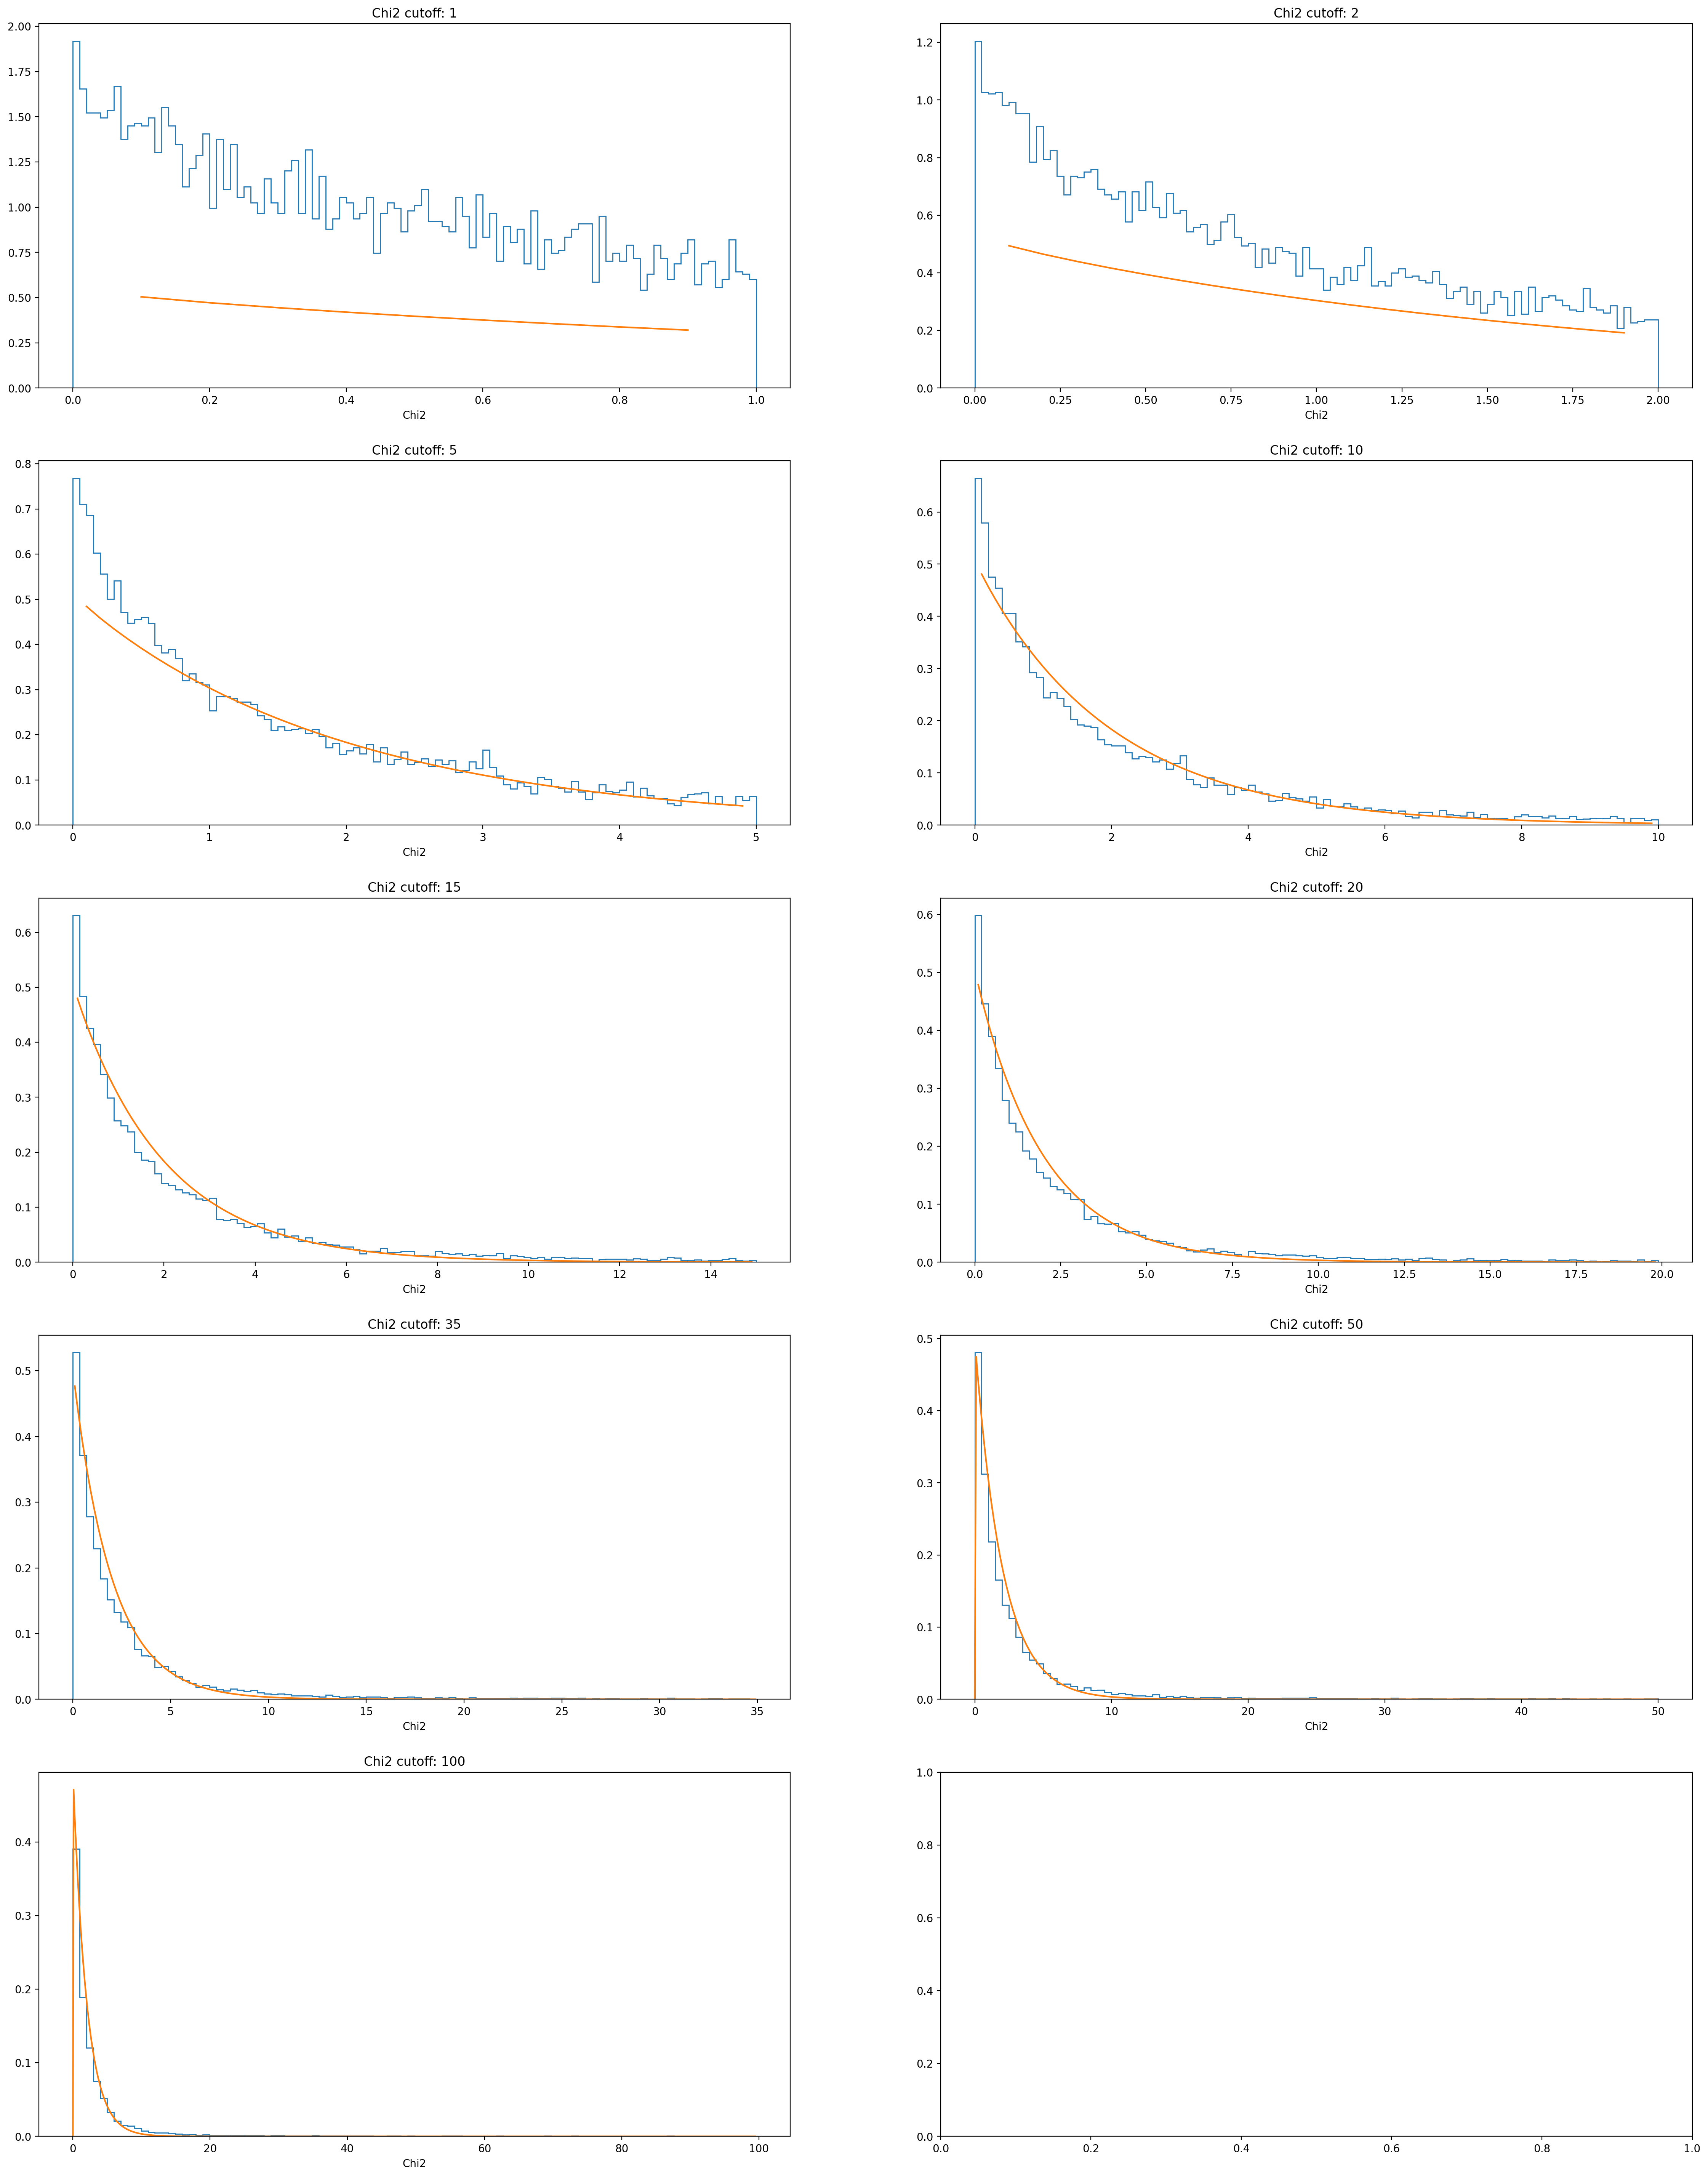

In [24]:
fig,axs=plt.subplots(int(len(cutoffs)/2 + 0.5),2,figsize=(7*int(len(cutoffs)/2), 8*len(cutoffs)/2))
axs=axs.flatten().tolist()

for i in range(len(cutoffs)):
    chi2Counts, chi2Bins = np.histogram(chi2s[i], bins=100)

    binsize = chi2Bins[1] - chi2Bins[0]
    chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)
    
    popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:-1], chi2Counts, sigma=sqrt(chi2Counts))
    binsize = chi2Bins[1] - chi2Bins[0]
    
    chi2Counts = chi2Counts / (sum(chi2Counts)*binsize)
    axs[i].stairs(chi2Counts, chi2Bins)
    axs[i].set_xlabel("Chi2")
    axs[i].set_title("Chi2 cutoff: " + str(cutoffs[i]))
    popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:-1], chi2Counts, sigma=sqrt(chi2Counts))
    print("ndof for chi2 cutoff of", cutoffs[i], ":", popt[0], "+/-", np.sqrt(pcov[0][0]))
    domain = np.arange(0, chi2Bins[-1], 0.1)
    chi2_fit = sp.stats.chi2.pdf(domain, popt[0], 0, 1)
    axs[i].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
    print("Efficiency:", len(chi2s[i])/nTracks)

## Efficiency of Vertex Vetoing ##

In [25]:
cutoffs = [1,2,5,10,15,20,35,50,100]
nCuts = []
nTracks = 0
nVertices = 0
for cutoff in cutoffs:
    nCuts.append(0)
for cut in cutoffs:
    for f in pathList:
        events=joblib.load(f)
        file_hits = events["hits"]
        file_tracks = events["tracks"]
        file_vertices = events["vertices"]
        for i in range(len(file_hits)):
            hits = file_hits[i]
            tracks = file_tracks[i]
            vertices = file_vertices[i]
            nTracks += len(tracks)
            nVertices += len(vertices)
            wf_hits = []
            for hit in hits:
                if hit.layer < 4:
                    wf_hits.append(hit)
            if len(wf_hits) == 0:
                continue
            for vertex in vertices:
                v_tracks = []
                for index in vertex.tracks:
                    v_tracks.append(tracks[index])
                    
                for track in v_tracks:
                    min_chi2 = None
                    for hit in wf_hits:
                        hit_pos = np.array((hit.x, hit.y, hit.z))
                        hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                        cur_chi2 = GetChiSquared(hit,track)
                        if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                            min_chi2 = cur_chi2
                    
                    if min_chi2 is None:
                        continue
                    chi2_red = min_chi2
                    for i in range(len(cutoffs)):
                        if chi2_red >0 and chi2_red < cutoffs[i]:
                            nCuts[i] += 1
                    break # Don't need to do another if we already got one


Text(0, 0.5, 'Percent of Vertices Vetoed')

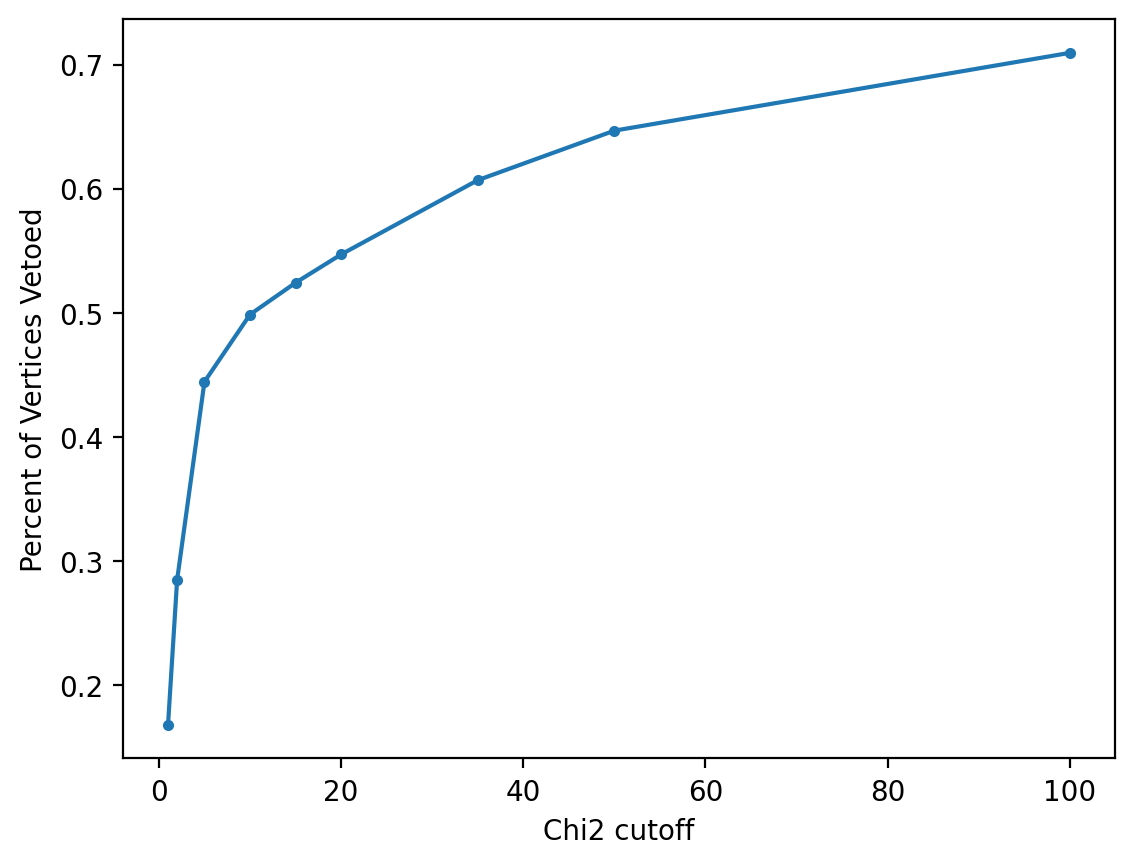

In [26]:
plt.plot(cutoffs, np.array(nCuts)/nVertices, marker=".")
plt.xlabel("Chi2 cutoff")
plt.ylabel("Percent of Vertices Vetoed")

# Signal Study #

In [33]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/LLP"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

5


## Chi2 and Distance Distribution (Track Level) ##

### Chi 2 Distribution and Chi2 vs Distance ###

In [31]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_chi2 = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                cur_chi2 = GetChiSquared(hit,track)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
                    min_hit = hit
                    min_time = abs(proj_time - hit.t)
                    min_point = proj_point
            if min_hit is None:
                continue
            dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
            chi2_red = min_chi2
            # if chi2_red > 0 and chi2_red < 5000:
            if chi2_red > 0:
                chi2s.append(chi2_red)
                distances.append(dist)
                times.append(min_time)

Text(0, 0.5, 'chi2')

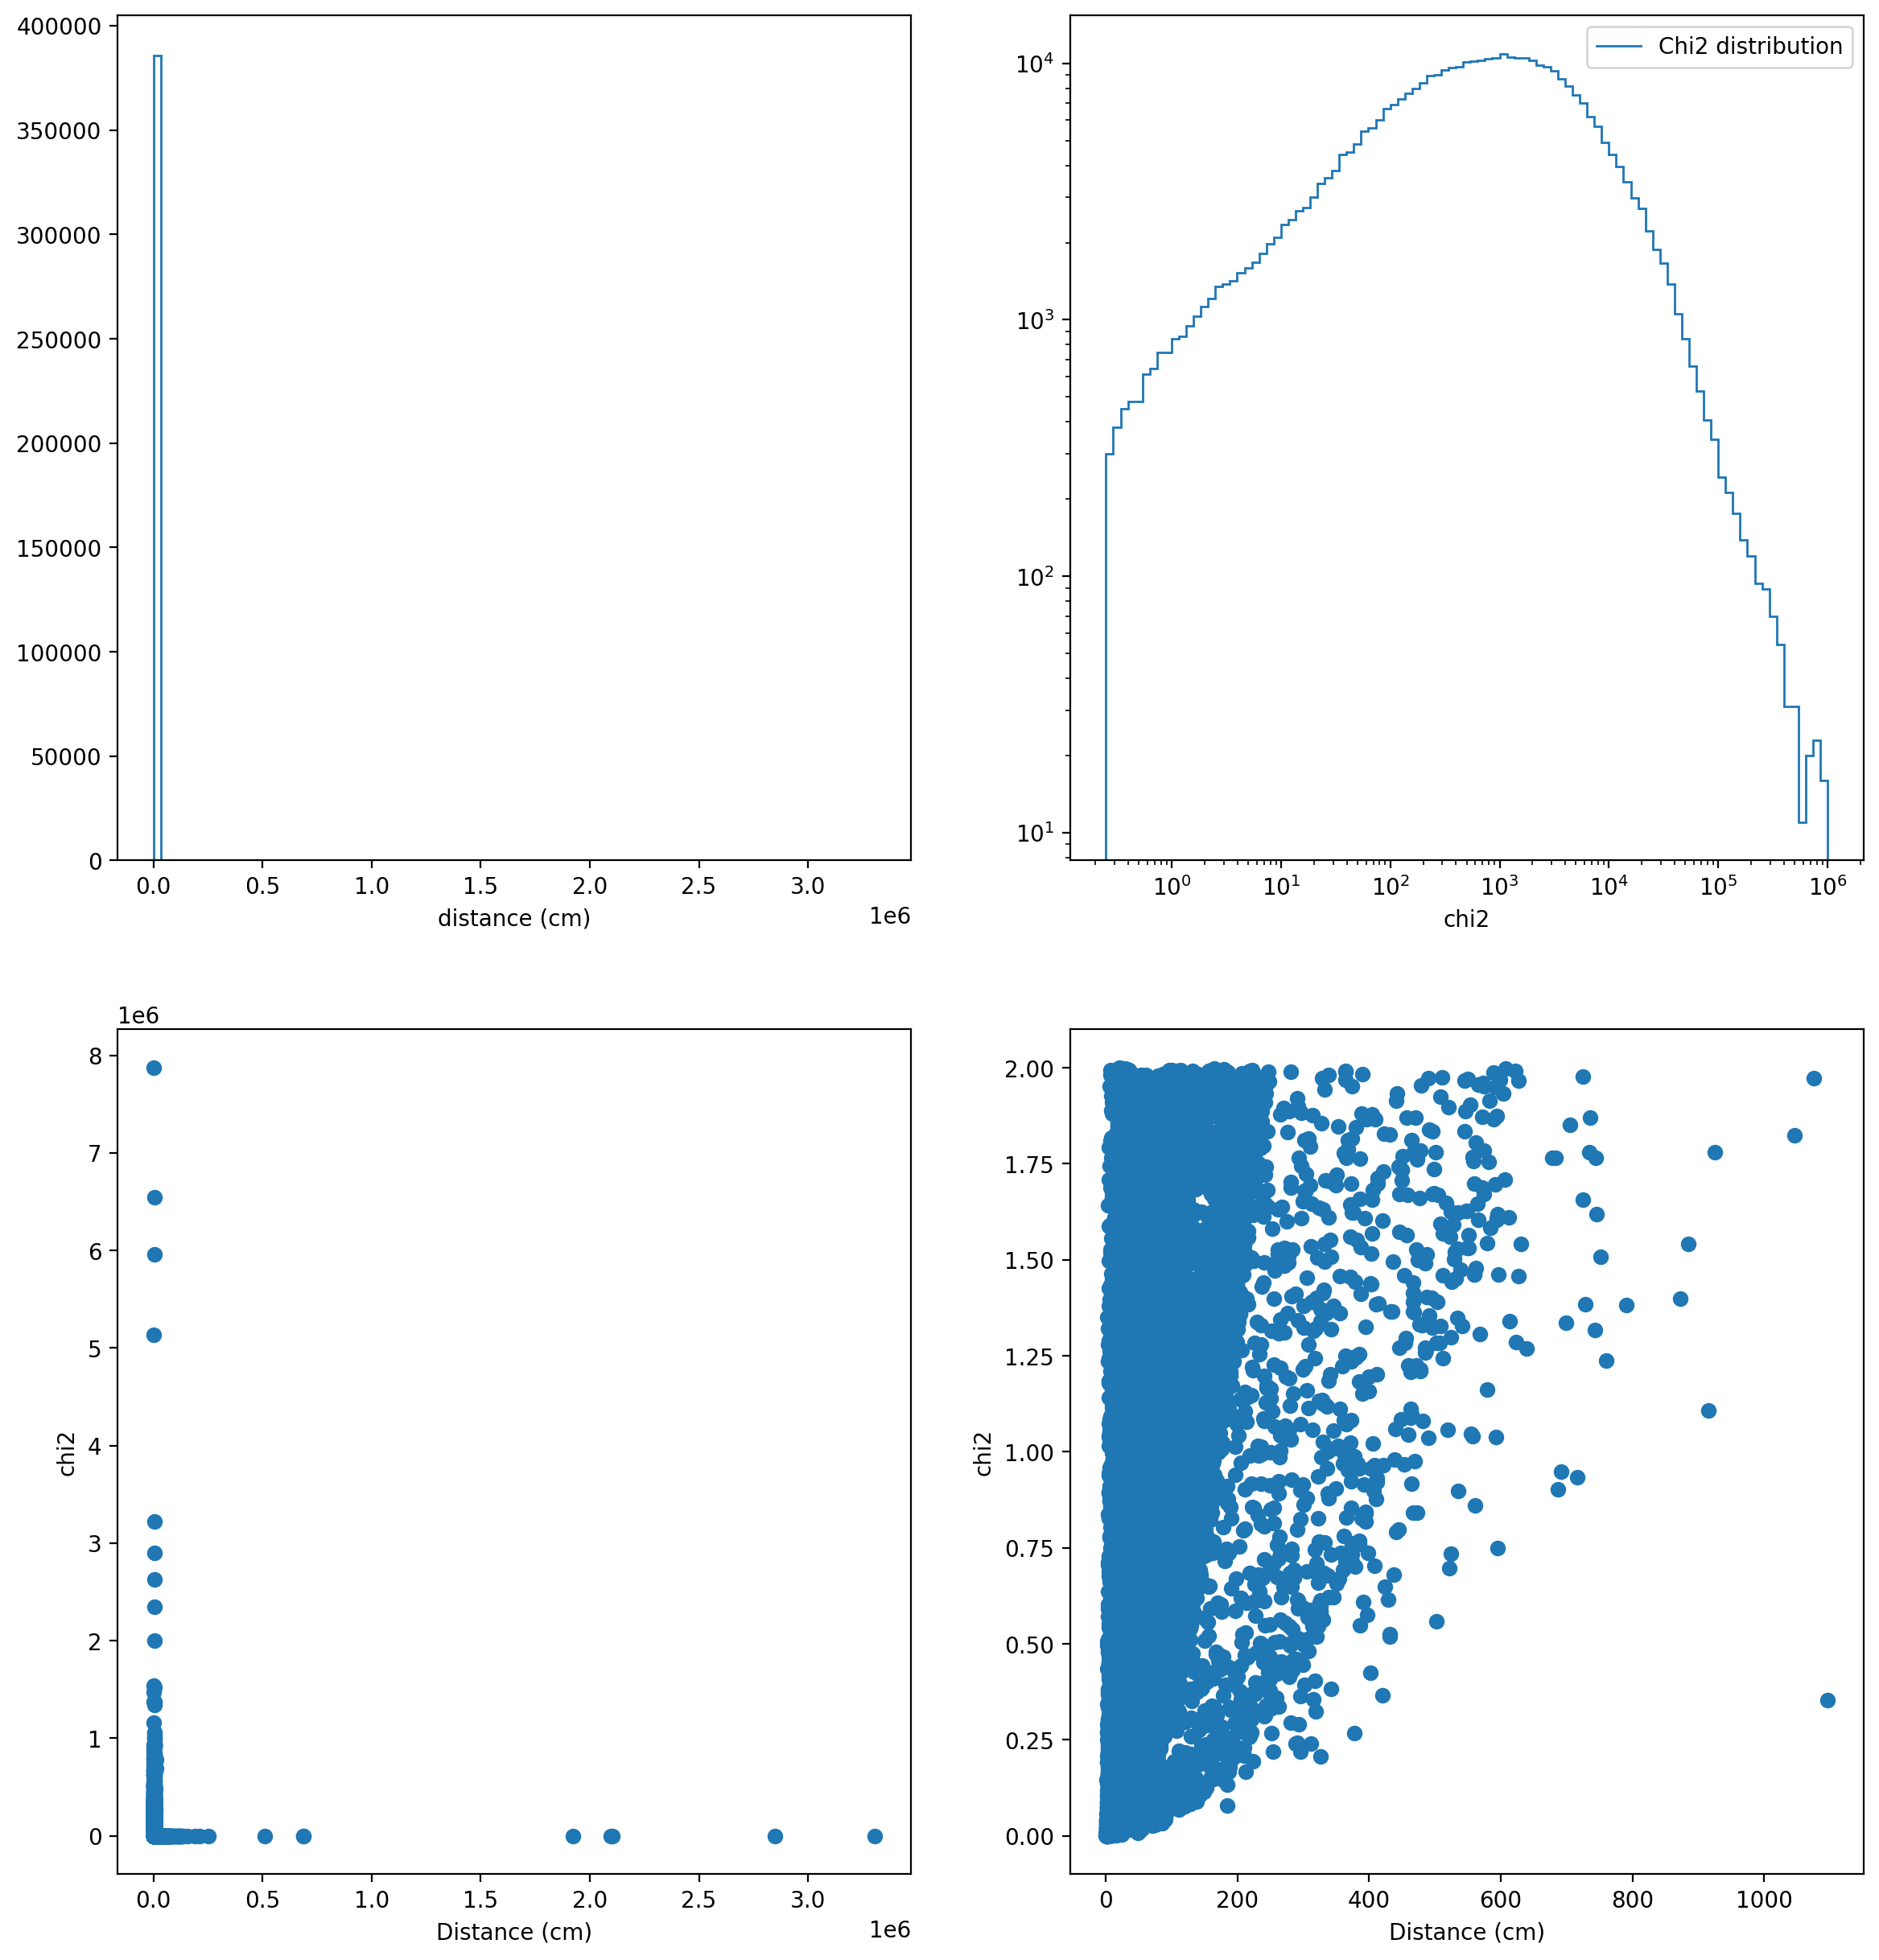

In [32]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=np.logspace(-0.6,6,100))

binsize = chi2Bins[1] - chi2Bins[0]
# chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 10:
    maxBin = i
    i+=1

# popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
# print(popt)
# print(np.sqrt(pcov))

# domain = np.arange(0, chi2Bins[-1], 0.1)

# chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
# chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
# axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2: ndof=2")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("chi2")
axs[1].set_xscale("log")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("chi2")

### Distance Distribution ###

In [73]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_dist = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                hit_pos = np.array((hit.x, hit.y, hit.z))
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                if proj_point is None:
                    continue
                dist = GetDistance(proj_point, hit_pos)
                if dist is not None and (min_dist is None or dist < min_dist):
                    min_dist = dist
            if min_dist is None:
                continue
            distances.append(min_dist)


Text(0.5, 1.0, 'Signal Distance Distribution')

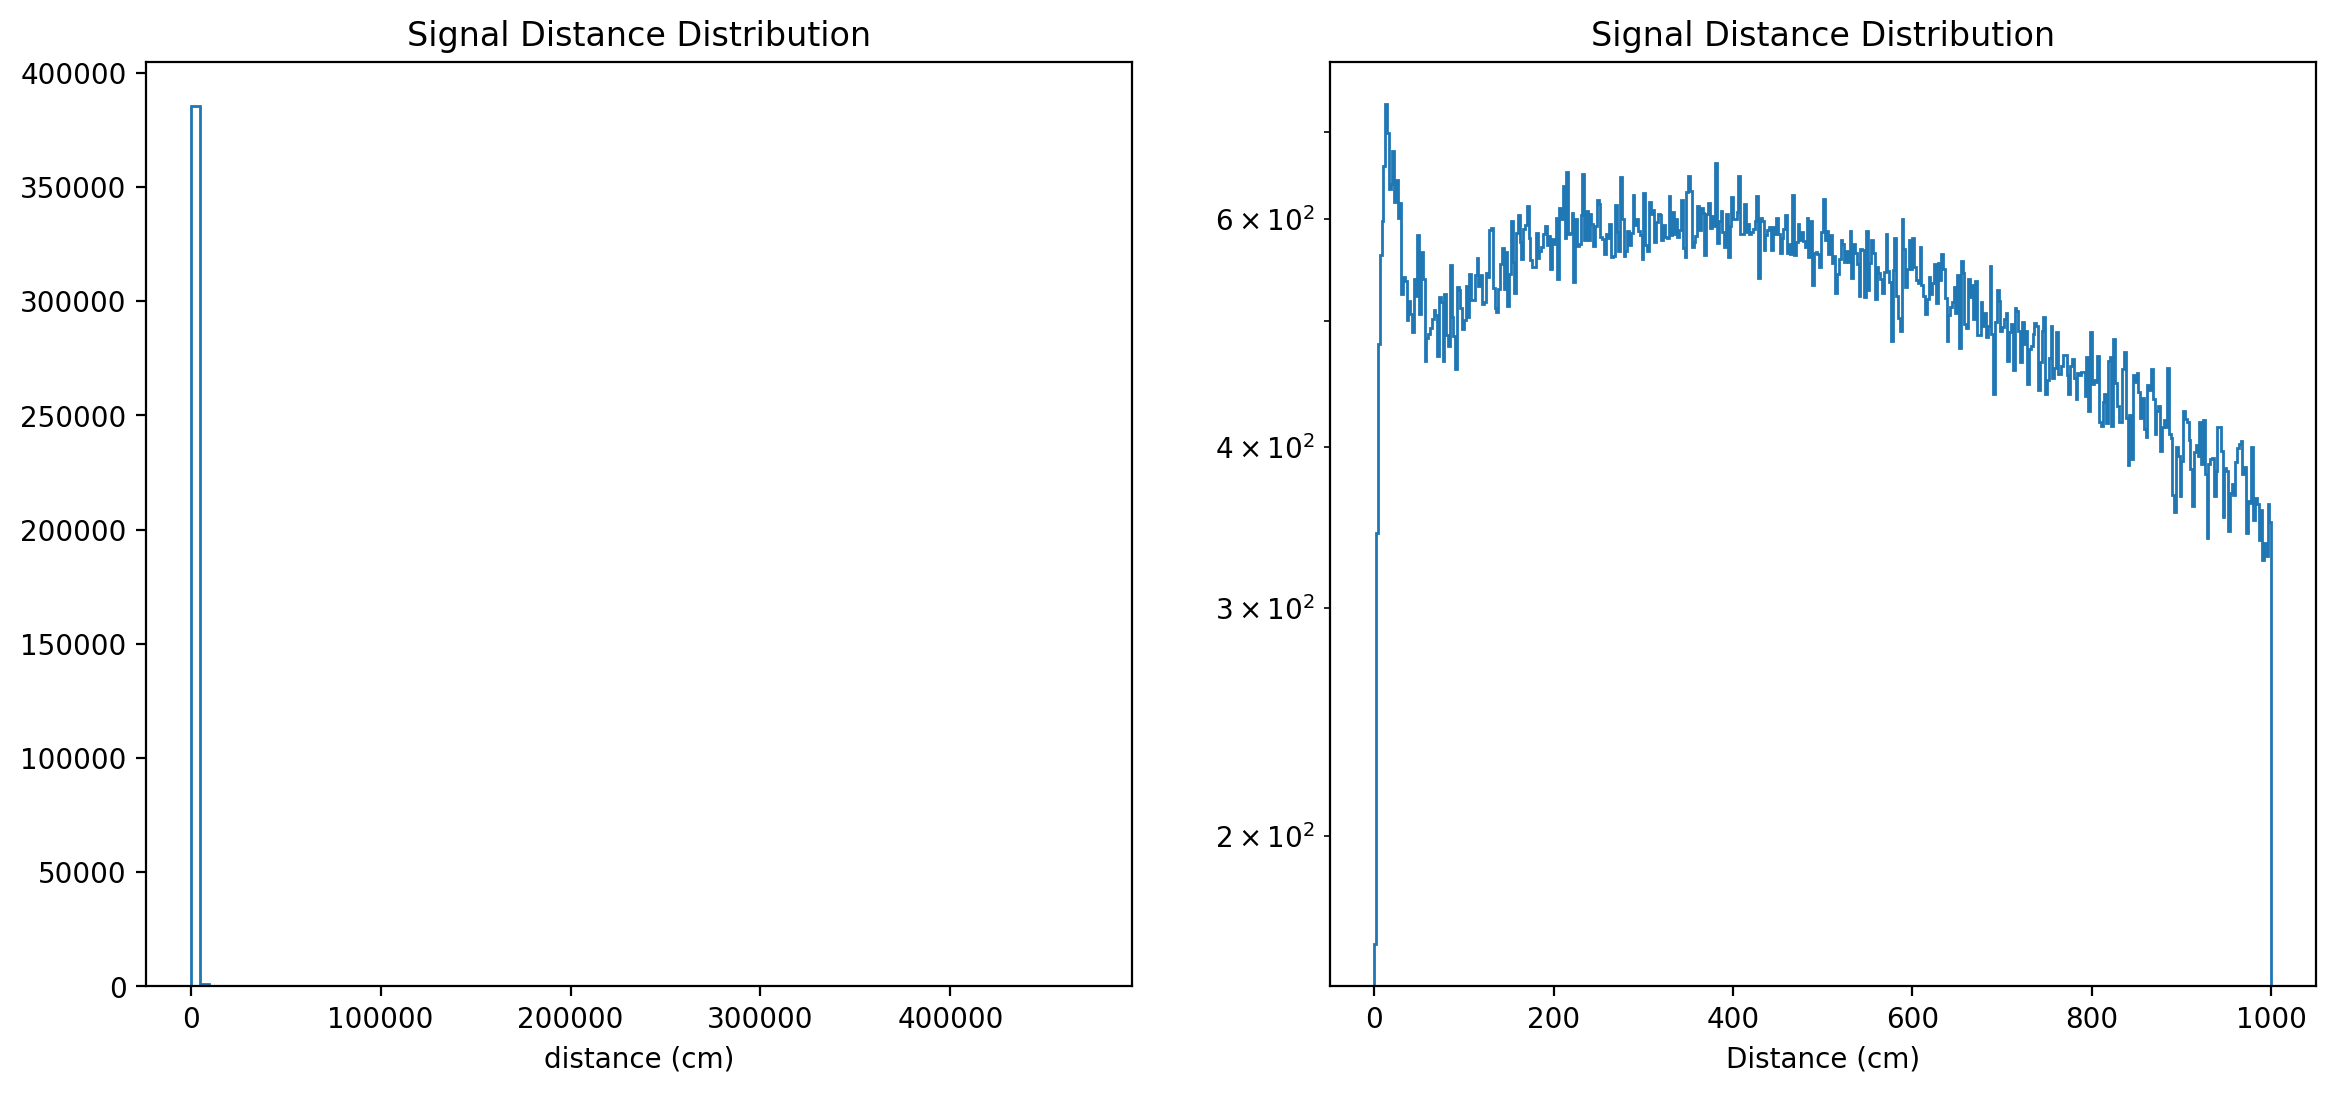

In [74]:
fig,axs=plt.subplots(1,2,figsize=(14,6))
axs=axs.flatten().tolist()

zoomeddist = []
for dist in distances:
    if dist < 1000:
        zoomeddist.append(dist)

distancesCounts, distancesBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=500)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_title("Signal Distance Distribution")
axs[1].stairs(zoomedCounts[:int(len(zoomedCounts)/1)], zoomedBins[:int(len(zoomedBins)/1) + 1], label="distances")
axs[1].set_yscale('log')
axs[1].set_xlabel("Distance (cm)")
axs[1].set_title("Signal Distance Distribution")

## Chi2 and Distance Distribution (Event Level) ##

### Chi2 Distribution ###

In [35]:
chi2s = []
chi2sNoise = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_chi2 = None
        min_hit = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_hit = hit
                        min_chi2 = cur_chi2
        if min_chi2 is None:
            continue
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 101:
            if min_hit.type == 2:
                chi2sNoise.append(chi2_red)
            chi2s.append(chi2_red)
print("Total Events (with at least one vertex):", nEvents)

Total Events (with at least one vertex): 46153


Text(0.5, 0, 'chi2')

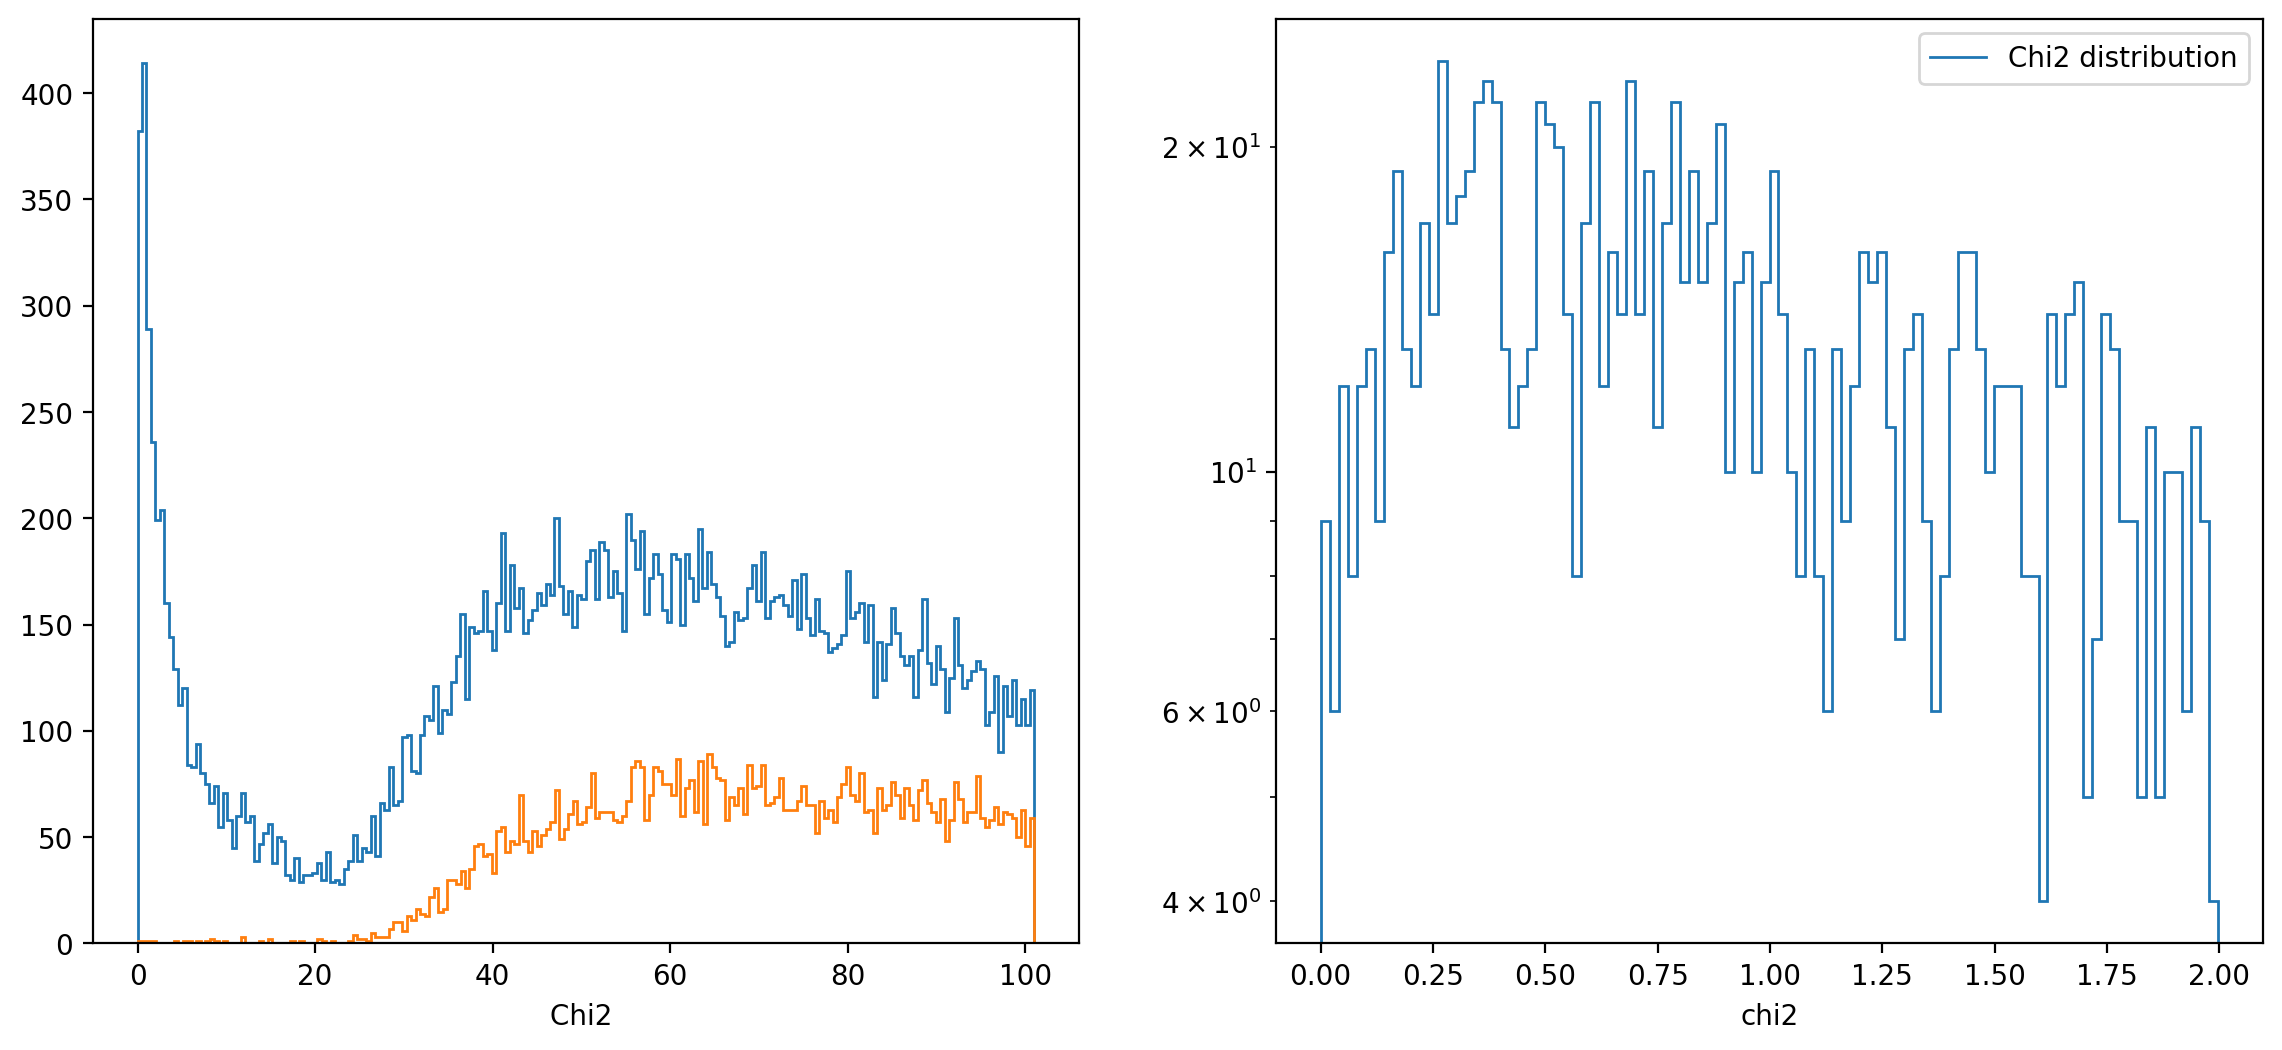

In [40]:
fig,axs=plt.subplots(1,2,figsize=(14,6))
axs=axs.flatten().tolist()

zoomedchis = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])

chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)
chi2NoiseCounts,chi2NoiseBins = np.histogram(chi2sNoise, bins=200)
zoomedCounts, zoomedBins = np.histogram(zoomedchis, bins=100)

axs[0].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 Distribution")
axs[0].stairs(chi2NoiseCounts, chi2NoiseBins, label="Chi2 Distribution From Noise")
axs[0].set_xlabel("Chi2 ")
axs[1].stairs(zoomedCounts[:int(len(zoomedCounts)/1)], zoomedBins[:int(len(zoomedCounts)/1) + 1], label="Chi2 distribution")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("chi2")


### Distance Distribution ###

In [41]:
distances = []
distancesNoise = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_dist = None
        min_hit = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    TrackPoints = SortByTime(track.hits_filtered)
                    proj_time = hit.t
                    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                    if proj_point is not None:
                        dist = GetDistance(hit_pos, proj_point)
                    if (min_dist is None or dist < min_dist):
                        min_dist = dist
                        min_hit = hit
                        
        if min_dist is None:
            continue
        distances.append(min_dist)
        if min_hit.type == 2:
            distancesNoise.append(min_dist)
print("Number of events with at least one vertex:", nEvents)


Number of events with at least one vertex: 46153


Text(0.5, 1.0, 'Signal Distance Distribution')

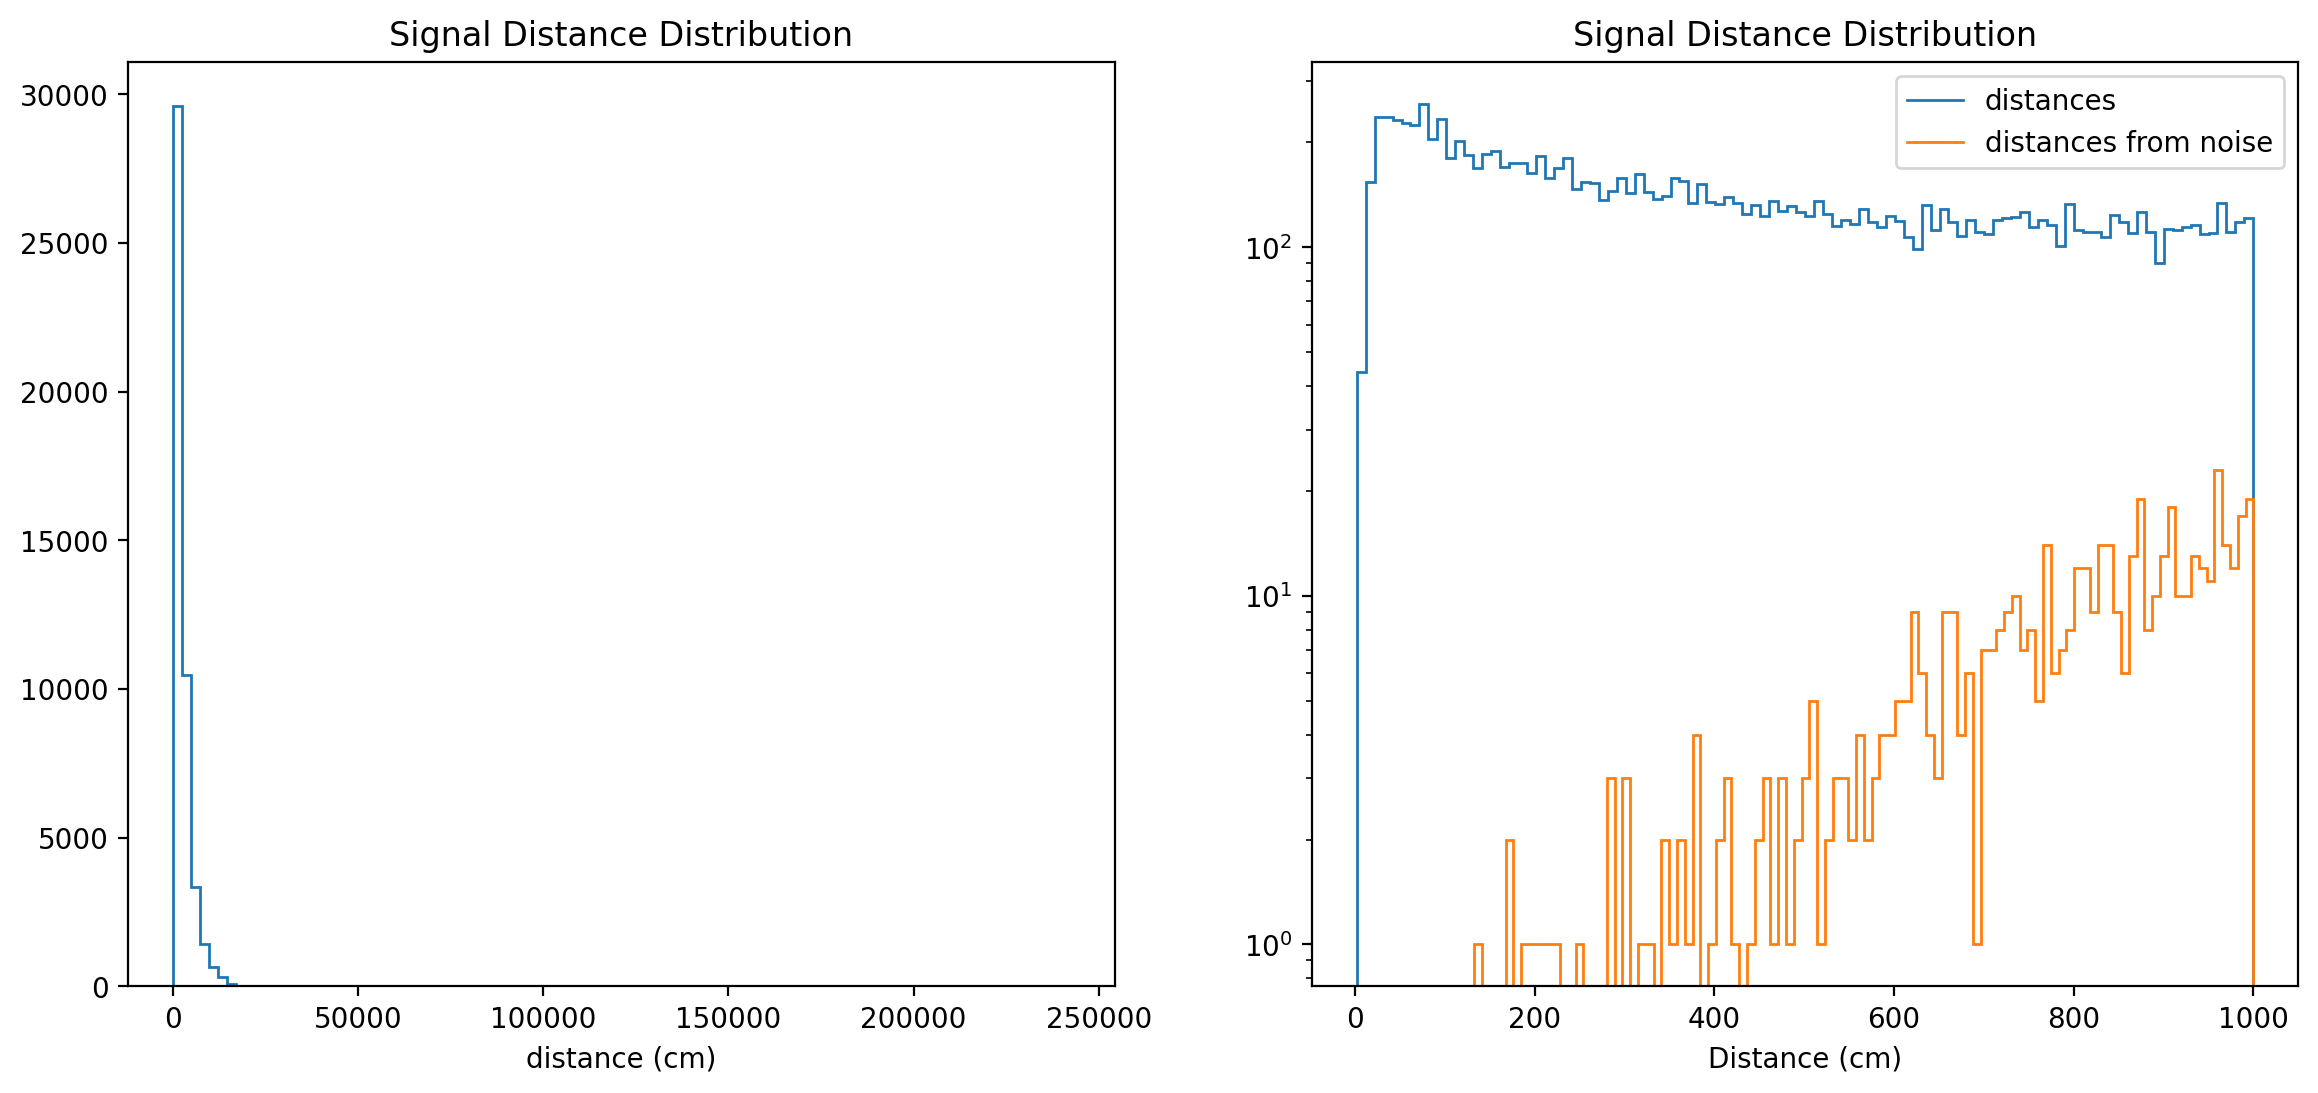

In [44]:
fig,axs=plt.subplots(1,2,figsize=(14,6))
axs=axs.flatten().tolist()

zoomeddist = []
zoomedNoiseDist = []
for dist in distances:
    if dist < 1000:
        zoomeddist.append(dist)
for dist in distancesNoise:
    if dist < 1000:
        zoomedNoiseDist.append(dist)

distancesCounts, distancesBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=100)
zoomedNoiseCounts, zoomedNoiseBins  = np.histogram(zoomedNoiseDist, bins=100)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_title("Signal Distance Distribution")
axs[1].stairs(zoomedCounts[:int(len(zoomedCounts)/1)], zoomedBins[:int(len(zoomedBins)/1) + 1], label="distances")
axs[1].stairs(zoomedNoiseCounts, zoomedNoiseBins, label="distances from noise")
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_xlabel("Distance (cm)")
axs[1].set_title("Signal Distance Distribution")

## Track Veto Efficiency ## 

### Survival Rate for Given Chi2 Values ###

In [54]:
chi2s = []
nTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        nTracks += len(tracks)
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_chi2 = None
            for hit in wf_hits:
                cur_chi2 = GetChiSquared(hit,track)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
            if min_chi2 is None:
                continue
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 50:
                chi2s.append(chi2_red)
print("Total Tracks:", nTracks)

Total Tracks: 451570


Fraction surviving after chi2=1 cut: 0.9811502092698806
Fraction surviving after chi2=5 cut: 0.9551852425980468
Fraction surviving after chi2=7 cut: 0.9471001173682928
Fraction surviving after chi2=10 cut: 0.9368713599220497


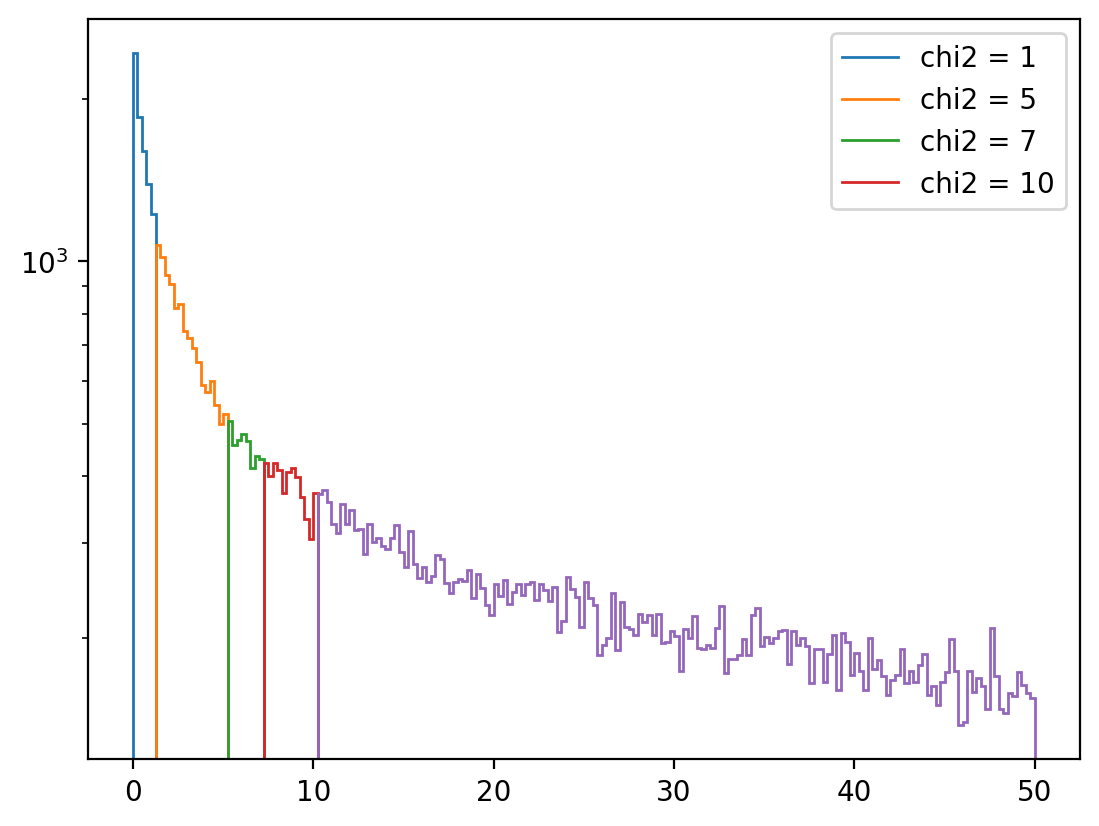

In [55]:
chi2_1Counts = []
chi2_5Counts = []
chi2_7Counts = []
chi2_10Counts = []
chi2_restCounts = []

chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

i=0
start_1 = 0
while chi2Bins[i] < 1:
    chi2_1Counts.append(chi2Counts[i])
    i+=1
n_1Bins = chi2Bins[start_1:start_1 + len(chi2_1Counts)+1]
start_5 = i
while chi2Bins[i] < 5:
    chi2_5Counts.append(chi2Counts[i])
    i+=1
n_5Bins = chi2Bins[start_5:start_5 + len(chi2_5Counts)+1]
start_7 = i
while chi2Bins[i] < 7:
    chi2_7Counts.append(chi2Counts[i])
    i+=1
n_7Bins = chi2Bins[start_7:start_7 + len(chi2_7Counts)+1]
start_10 = i
while chi2Bins[i] < 10:
    chi2_10Counts.append(chi2Counts[i])
    i+=1
n_10Bins = chi2Bins[start_10:start_10 + len(chi2_10Counts)+1]
start_rest = i
while i < len(chi2Bins) - 1:
    chi2_restCounts.append(chi2Counts[i])
    i+=1
n_rest = chi2Bins[start_rest:start_rest + len(chi2_restCounts)+1]
frac_1 = 1 - sum(chi2_1Counts)/nTracks; frac_5 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts))/nTracks
frac_7 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts) + sum(chi2_7Counts))/nTracks
frac_10 = 1 - (sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nTracks
print("Fraction surviving after chi2=1 cut:", frac_1)
print("Fraction surviving after chi2=5 cut:", frac_5)
print("Fraction surviving after chi2=7 cut:", frac_7)
print("Fraction surviving after chi2=10 cut:", frac_10)
plt.stairs(chi2_1Counts, n_1Bins, label="chi2 = 1")
plt.stairs(chi2_5Counts, n_5Bins, label="chi2 = 5")
plt.stairs(chi2_7Counts, n_7Bins, label="chi2 = 7")
plt.stairs(chi2_10Counts, n_10Bins,label="chi2 = 10")
plt.stairs(chi2_restCounts, n_rest)
plt.yscale('log')
plt.legend()

### Survival Rate for Given Distance Values ###

In [26]:
distances = []
nTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        nTracks += len(tracks)
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_dist = None
            for hit in wf_hits:
                hit_pos = np.array((hit.x, hit.y, hit.z))
                TrackPoints = SortByTime(track.hits_filtered)
                proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                if proj_point is None:
                    continue
                dist = GetDistance(hit_pos, proj_point)
                if (min_dist is None or dist < min_dist):
                    min_dist = dist
            if min_dist is None:
                continue
            distances.append(min_dist)
print("Total number of tracks:", nTracks)


Total number of tracks: 451570


999.9956726039143
Fraction surviving after d=100 cut: 0.9412671346635073
Fraction surviving after d=200 cut: 0.8798879464977745
Fraction surviving after d=300 cut: 0.8145780277697809
Fraction surviving after d=500 cut: 0.6838253205483092


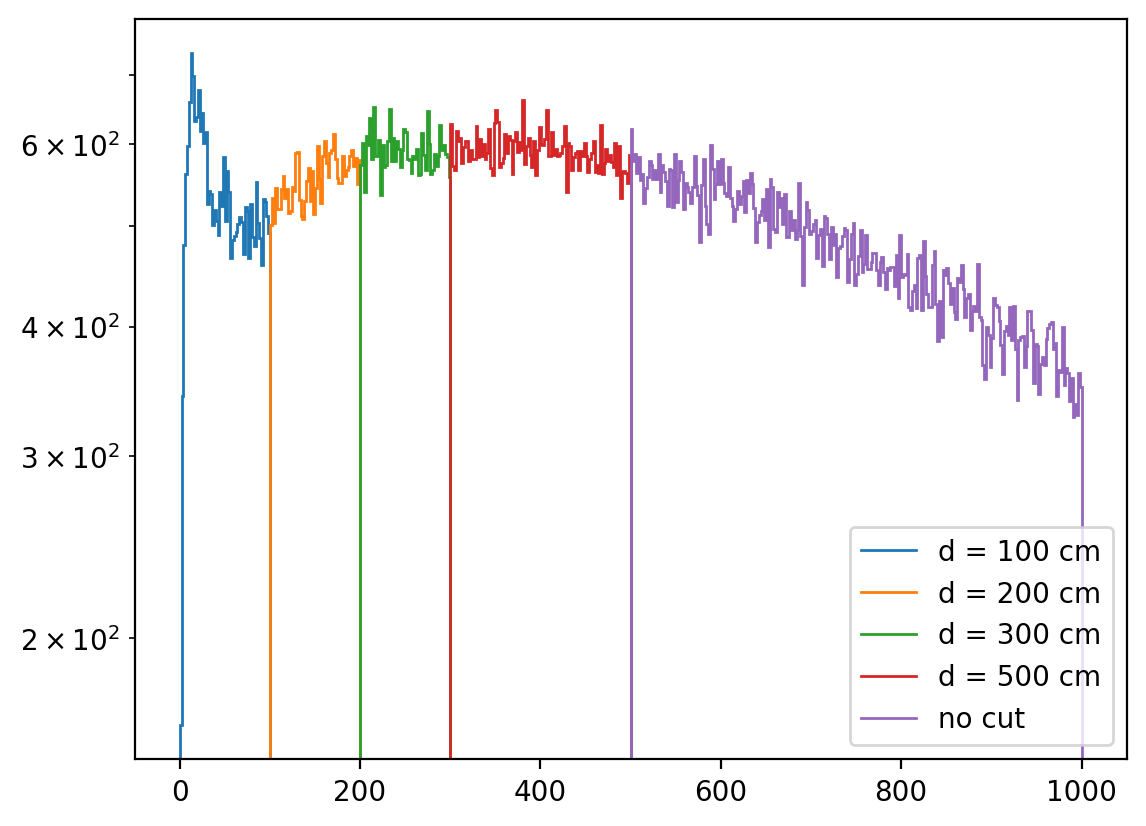

In [27]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dist_shortened = []
for dist in distances:
    if dist < 1000:
        dist_shortened.append(dist)
dCounts, dBins = np.histogram(dist_shortened, bins=500)
print(dBins[-1])

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nTracks; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nTracks
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nTracks
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nTracks
print("Fraction surviving after d=100 cut:", frac_1)
print("Fraction surviving after d=200 cut:", frac_2)
print("Fraction surviving after d=300 cut:", frac_3)
print("Fraction surviving after d=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="d = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="d = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="d = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="d = 500 cm")
plt.stairs(d_restCounts, n_rest, label="no cut")
plt.yscale('log')
plt.legend()

## Event Veto Efficiency ##

### Survival Rate for given Chi2 Values ###

In [28]:
chi2s = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_chi2 = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
        if min_chi2 is None:
            continue
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 101:
            chi2s.append(chi2_red)
print("Total Events (with at least one vertex):", nEvents)

Total Events (with at least one vertex): 46153


Fraction surviving after chi2=1 cut: 0.9827530171386475
Fraction surviving after chi2=5 cut: 0.950837432019587
Fraction surviving after chi2=7 cut: 0.9425822806751457
Fraction surviving after chi2=10 cut: 0.9334604467748575
Fraction surviving after chi2=15 cut: 0.9216518969514441
Fraction surviving after chi2=20 cut: 0.9137650856932377
Fraction surviving after chi2=50 cut: 0.7686174246527853
Fraction surviving after chi2=100 cut: 0.4451931618746343


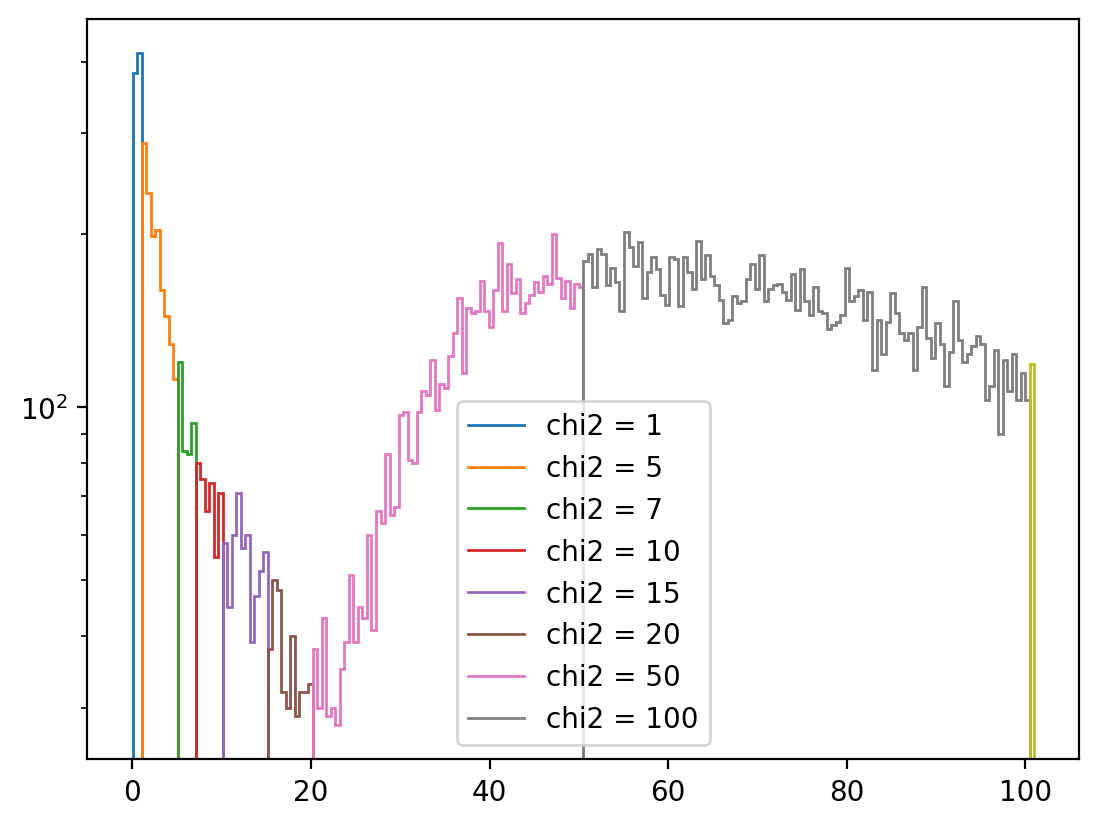

In [29]:
chi2_1Counts = []
chi2_5Counts = []
chi2_7Counts = []
chi2_10Counts = []
chi2_15Counts = []
chi2_20Counts = []
chi2_50Counts = []
chi2_100Counts = []
chi2_restCounts = []

chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

i=0
start_1 = 0
while chi2Bins[i] < 1:
    chi2_1Counts.append(chi2Counts[i])
    i+=1
n_1Bins = chi2Bins[start_1:start_1 + len(chi2_1Counts)+1]
start_5 = i
while chi2Bins[i] < 5:
    chi2_5Counts.append(chi2Counts[i])
    i+=1
n_5Bins = chi2Bins[start_5:start_5 + len(chi2_5Counts)+1]
start_7 = i
while chi2Bins[i] < 7:
    chi2_7Counts.append(chi2Counts[i])
    i+=1
n_7Bins = chi2Bins[start_7:start_7 + len(chi2_7Counts)+1]
start_10 = i
while chi2Bins[i] < 10:
    chi2_10Counts.append(chi2Counts[i])
    i+=1
n_10Bins = chi2Bins[start_10:start_10 + len(chi2_10Counts)+1]
start_15 = i
while chi2Bins[i] < 15:
    chi2_15Counts.append(chi2Counts[i])
    i+=1
n_15Bins = chi2Bins[start_15:start_15 + len(chi2_15Counts)+1]
start_20 = i
while chi2Bins[i] < 20:
    chi2_20Counts.append(chi2Counts[i])
    i+=1
n_20Bins = chi2Bins[start_20:start_20 + len(chi2_20Counts)+1]
start_50 = i
while chi2Bins[i] < 50:
    chi2_50Counts.append(chi2Counts[i])
    i+=1
n_50Bins = chi2Bins[start_50:start_50 + len(chi2_50Counts)+1]
start_100 = i
while chi2Bins[i] < 100:
    chi2_100Counts.append(chi2Counts[i])
    i+=1
n_100Bins = chi2Bins[start_100:start_100 + len(chi2_100Counts)+1]
start_rest = i
while i < len(chi2Bins) - 1:
    chi2_restCounts.append(chi2Counts[i])
    i+=1
n_rest = chi2Bins[start_rest:start_rest + len(chi2_restCounts)+1]
frac_1 = 1 - sum(chi2_1Counts)/nEvents; frac_5 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts))/nEvents
frac_7 = 1 - (sum(chi2_1Counts) + sum(chi2_5Counts) + sum(chi2_7Counts))/nEvents
frac_10 = 1 - (sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_15 = 1 - (sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_20 = 1 - (sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_50 = 1 - (sum(chi2_50Counts) + sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents
frac_100 = 1 - (sum(chi2_100Counts) + sum(chi2_50Counts) + sum(chi2_20Counts) + sum(chi2_15Counts) + sum(chi2_10Counts) + sum(chi2_7Counts) + sum(chi2_5Counts) + sum(chi2_1Counts))/nEvents

print("Fraction surviving after chi2=1 cut:", frac_1)
print("Fraction surviving after chi2=5 cut:", frac_5)
print("Fraction surviving after chi2=7 cut:", frac_7)
print("Fraction surviving after chi2=10 cut:", frac_10)
print("Fraction surviving after chi2=15 cut:", frac_15)
print("Fraction surviving after chi2=20 cut:", frac_20)
print("Fraction surviving after chi2=50 cut:", frac_50)
print("Fraction surviving after chi2=100 cut:", frac_100)
plt.stairs(chi2_1Counts, n_1Bins, label="chi2 = 1")
plt.stairs(chi2_5Counts, n_5Bins, label="chi2 = 5")
plt.stairs(chi2_7Counts, n_7Bins, label="chi2 = 7")
plt.stairs(chi2_10Counts, n_10Bins,label="chi2 = 10")
plt.stairs(chi2_15Counts, n_15Bins,label="chi2 = 15")
plt.stairs(chi2_20Counts, n_20Bins,label="chi2 = 20")
plt.stairs(chi2_50Counts, n_50Bins,label="chi2 = 50")
plt.stairs(chi2_100Counts, n_100Bins,label="chi2 = 100")

plt.stairs(chi2_restCounts, n_rest)
plt.yscale('log')
plt.legend()

### Survival Rate for Given Distance Values ###

In [17]:
distances = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        wf_hits = []
        if len(vertices) == 0:
            continue
        nEvents += 1
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_dist = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    TrackPoints = SortByTime(track.hits_filtered)
                    proj_time = hit.t
                    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                    if proj_point is not None:
                        dist = GetDistance(hit_pos, proj_point)
                    if (min_dist is None or dist < min_dist):
                        min_dist = dist
        if min_dist is None:
            continue
        distances.append(min_dist)
print("Number of events with at least one vertex:", nEvents)


Number of events with at least one vertex: 46153


Fraction surviving after d=100 cut: 0.9555391848850562
Fraction surviving after d=200 cut: 0.9166901393192208
Fraction surviving after d=300 cut: 0.8823478430437891
Fraction surviving after d=500 cut: 0.8223517431152905
Fraction surviving after d=700 cut: 0.7708707992979871
Fraction surviving after d=1000 cut: 0.6959027582172339


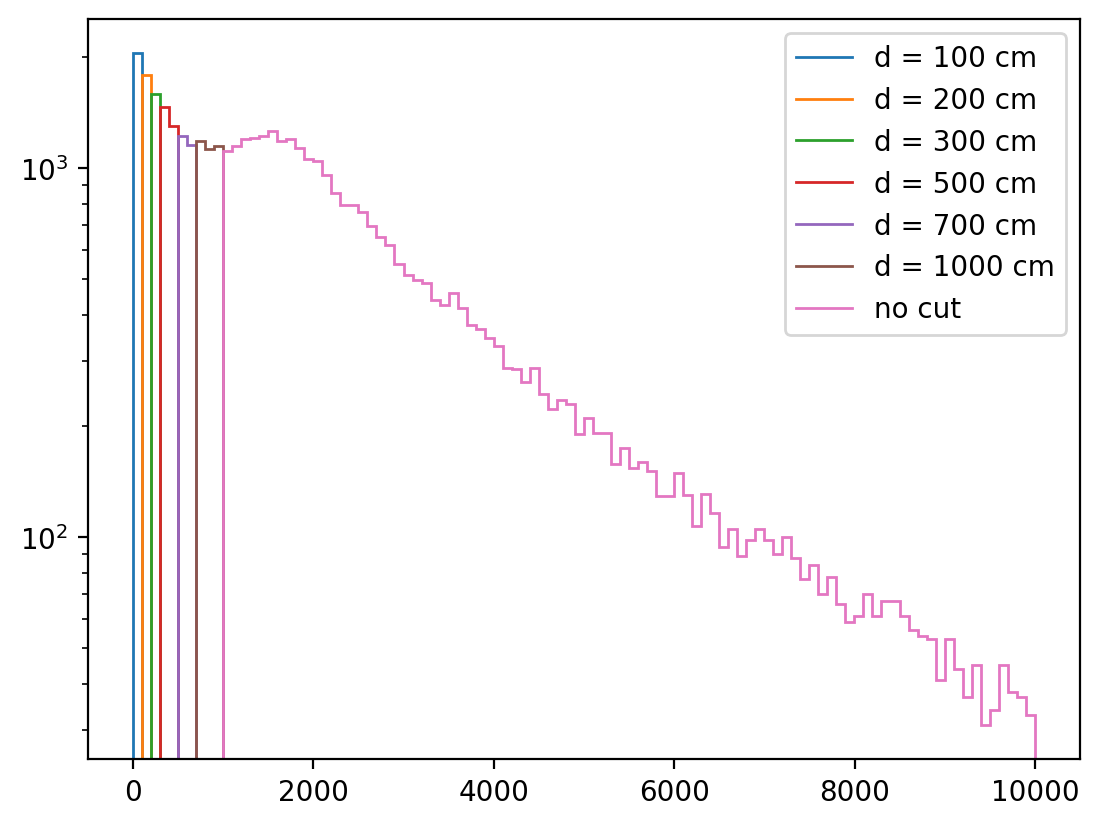

In [18]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_7Counts = []
d_10Counts = []
d_restCounts = []

dist_shortened = []
for dist in distances:
    if dist < 10001:
        dist_shortened.append(dist)
dCounts, dBins = np.histogram(dist_shortened, bins=100)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_7 = i
while dBins[i] < 700:
    d_7Counts.append(dCounts[i])
    i+=1
n_7Bins = dBins[start_7:start_7 + len(d_7Counts)+1]
start_10 = i
while dBins[i] < 1000:
    d_10Counts.append(dCounts[i])
    i+=1
n_10Bins = dBins[start_10:start_10 + len(d_10Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nEvents; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nEvents
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nEvents
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nEvents
frac_7 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts) + sum(d_7Counts))/nEvents
frac_10 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts) + sum(d_7Counts) + sum(d_10Counts))/nEvents

print("Fraction surviving after d=100 cut:", frac_1)
print("Fraction surviving after d=200 cut:", frac_2)
print("Fraction surviving after d=300 cut:", frac_3)
print("Fraction surviving after d=500 cut:", frac_5)
print("Fraction surviving after d=700 cut:", frac_7)
print("Fraction surviving after d=1000 cut:", frac_10)

plt.stairs(d_1Counts, n_1Bins, label="d = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="d = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="d = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="d = 500 cm")
plt.stairs(d_7Counts, n_7Bins, label="d = 700 cm")
plt.stairs(d_10Counts, n_10Bins, label="d = 1000 cm")
plt.stairs(d_restCounts, n_rest, label="no cut")
plt.yscale('log')
plt.legend()